--- 1. Sweeping Theta Angle (Vacuum Structure) ---


100%|██████████| 21/21 [01:04<00:00,  3.06s/it]



--- 2. Sweeping Mass (Chiral Condensate) ---


100%|██████████| 21/21 [01:10<00:00,  3.37s/it]


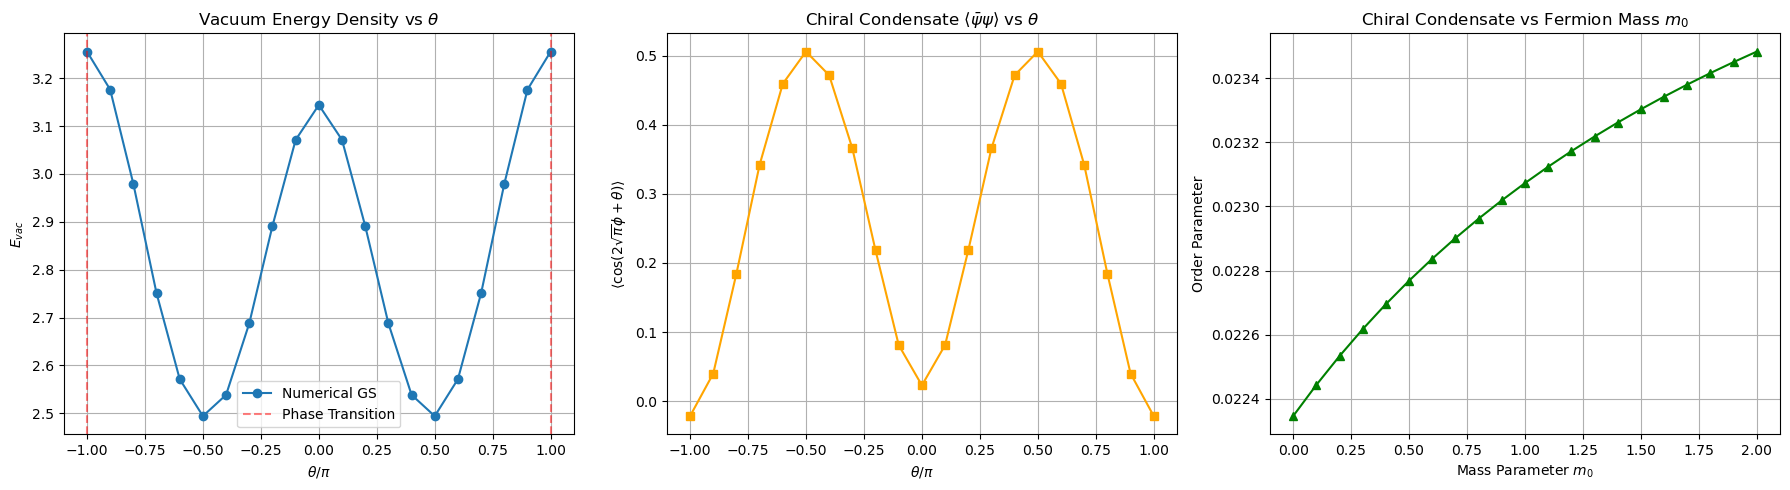

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye, diags
from scipy.sparse.linalg import eigsh
from scipy.linalg import expm
from tqdm import tqdm

# ==========================================
# 1. PARAMETERS & CONFIGURATION
# ==========================================
params = {
    "N_SITES": 9,           # Keep small for exact diagonalization (Dim = Levels^N)
    "N_LEVELS": 4,          # Fock space truncation (needs to be higher for Cosine term convergence)
    "A": 1.0,               # Lattice spacing
    "G": 1.0,               # Coupling constant (e)
    "MASS": 0.5,            # Fermion mass (m0)
    "THETA": 0.0,           # Theta vacuum angle
    "K_CUTOFF": 30          # Number of eigenvalues to solve for
}

# Derived Physics Constants for Bosonization
# Massless scalar mass squared: mu^2 = g^2 / pi
# Bosonized mass term coeff: proportional to mass * g
params["SCALAR_MU_SQ"] = (params["G"]**2) / np.pi
params["COS_COEFF"] = params["MASS"] * params["G"] # Simplified scaling

# ==========================================
# 2. HAMILTONIAN CONSTRUCTION
# ==========================================

class MassiveSchwingerHamiltonian:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        self.n_sites = p["N_SITES"]
        
        # --- Local Operators (Fock Basis) ---
        # Annihilation operator a
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        
        # Field Phi = 1/sqrt(2*omega) * (a + a_dag)
        # For lattice scalar theory, effective local frequency is often set to 1 for basis construction
        # We assume expansion around a harmonic oscillator with w=1 for the basis
        w_basis = 1.0 
        self.phi_mat = (1.0 / np.sqrt(2 * w_basis)) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(w_basis / 2.0) * (self.a_mat - self.adag_mat)
        
        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)
        
        # --- The Massive Term (Sine-Gordon) ---
        # Operator: cos(2 * sqrt(pi) * phi + theta)
        # We calculate this using matrix exponentiation on the dense local operator
        sqrt_pi = np.sqrt(np.pi)
        
        # We construct the exponential e^{i * (2*sqrt(pi)*phi + theta)}
        arg_mat = 1j * (2 * sqrt_pi * self.phi_mat + self.p["THETA"] * self.id_mat)
        exp_plus = expm(arg_mat)
        exp_minus = expm(-arg_mat)
        
        # cos(X) = (e^iX + e^-iX) / 2
        self.cos_mat = 0.5 * (exp_plus + exp_minus)

        # Pre-build Identity for Kron
        self.id_full = eye(self.dim ** self.n_sites, format='csr')

    def build_hamiltonian(self, theta=None, mass=None):
        """
        Constructs H_massive = H_free + H_mass
        Allows overriding theta/mass for sweeping phase transitions.
        """
        current_theta = theta if theta is not None else self.p["THETA"]
        current_mass = mass if mass is not None else self.p["MASS"]
        
        # Re-calculate local cos matrix if theta changes
        if theta is not None:
            sqrt_pi = np.sqrt(np.pi)
            arg_mat = 1j * (2 * sqrt_pi * self.phi_mat + current_theta * self.id_mat)
            exp_plus = expm(arg_mat)
            exp_minus = expm(-arg_mat)
            local_cos = 0.5 * (exp_plus + exp_minus)
        else:
            local_cos = self.cos_mat

        dim_full = self.dim ** self.n_sites
        H = csr_matrix((dim_full, dim_full))
        
        # Coefficients
        a = self.p["A"]
        # Lattice Scalar Theory Discretization:
        # H = sum [ 1/(2a) * Pi^2  +  a/2 * ((phi_{n+1}-phi_n)/a)^2  +  a/2 * mu^2 * phi^2  -  a * coeff * cos(...) ]
        
        c_pi = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a) # becomes (1/2a) * (phi_i - phi_j)^2
        c_mass_term = 0.5 * a * self.p["SCALAR_MU_SQ"] # The "massless" Schwinger mass (e^2/pi)
        c_sg = -1.0 * a * current_mass * self.p["G"]   # The fermion mass term (Sine-Gordon interaction)

        # 1. On-Site Terms (Pi^2, Phi^2, Cos)
        for i in range(self.n_sites):
            # Kinetic (Pi^2)
            H += c_pi * self._embed_operator(self.pi2_mat, i)
            # Massless Potential (Phi^2)
            H += c_mass_term * self._embed_operator(self.phi2_mat, i)
            # Massive Fermion Term (Cos)
            H += c_sg * self._embed_operator(local_cos, i)
            
            # Gradient Self-Interaction part: (phi_i - phi_{i+1})^2 = phi_i^2 + phi_{i+1}^2 - 2phi_i phi_{i+1}
            # Add the phi^2 parts here (boundary conditions open)
            n_neighbors = 1 if (i == 0 or i == self.n_sites-1) else 2
            H += c_grad * n_neighbors * self._embed_operator(self.phi2_mat, i)

        # 2. Interaction Terms (Gradient Cross Terms: -2 * phi_i * phi_{i+1})
        for i in range(self.n_sites - 1):
            term = self._embed_two_site_op(self.phi_mat, self.phi_mat, i, i+1)
            H -= 2.0 * c_grad * term
            
        return H

    def _embed_operator(self, op, site_idx):
        """Embeds a single-site operator into the full Hilbert space."""
        # Using a list of operators and Kronecker product
        ops_list = [self.id_mat] * self.n_sites
        ops_list[site_idx] = op
        
        full_op = csr_matrix(ops_list[0])
        for k in range(1, self.n_sites):
            full_op = kron(full_op, csr_matrix(ops_list[k]), format='csr')
        return full_op

    def _embed_two_site_op(self, op1, op2, site1, site2):
        ops_list = [self.id_mat] * self.n_sites
        ops_list[site1] = op1
        ops_list[site2] = op2
        
        full_op = csr_matrix(ops_list[0])
        for k in range(1, self.n_sites):
            full_op = kron(full_op, csr_matrix(ops_list[k]), format='csr')
        return full_op

    def get_vacuum_expectation(self, state_vec, theta=None):
        """Calculates <Psi|Cos|Psi> averaged over lattice."""
        # Re-calc local cos if needed
        if theta is not None:
            sqrt_pi = np.sqrt(np.pi)
            arg_mat = 1j * (2 * sqrt_pi * self.phi_mat + theta * self.id_mat)
            local_cos = 0.5 * (expm(arg_mat) + expm(-arg_mat))
        else:
            local_cos = self.cos_mat

        total_exp = 0.0
        for i in range(self.n_sites):
            op = self._embed_operator(local_cos, i)
            # <psi | O | psi>
            val = state_vec.conj().T @ (op @ state_vec)
            total_exp += val.real
        return total_exp / self.n_sites

# ==========================================
# 3. PHASE TRANSITION STUDY
# ==========================================

def run_vacuum_study():
    # Setup System
    # Note: N_SITES=5, N_LEVELS=6 results in matrix size 6^5 = 7776. Feasible.
    sim_params = params.copy()
    sim_params["N_SITES"] = 5
    sim_params["N_LEVELS"] = 6
    
    model = MassiveSchwingerHamiltonian(sim_params)
    
    # Study 1: Theta Vacuum Periodicity & Phase Transition
    # Range from -Pi to +Pi. According to Coleman, phase transition at |theta|=pi
    thetas = np.linspace(-np.pi, np.pi, 21)
    energies = []
    condensates = []
    
    print("--- 1. Sweeping Theta Angle (Vacuum Structure) ---")
    for th in tqdm(thetas):
        H = model.build_hamiltonian(theta=th)
        # Find Ground State
        vals, vecs = eigsh(H, k=1, which='SA') # SA = Smallest Algebraic
        gs_energy = vals[0]
        gs_vec = vecs[:, 0]
        
        # Measure Chiral Condensate (Order Parameter)
        # Sigma ~ <cos(2*sqrt(pi)*phi + theta)>
        cond = model.get_vacuum_expectation(gs_vec, theta=th)
        
        energies.append(gs_energy)
        condensates.append(cond)
        
    # Study 2: Mass Dependence (Confinement Strength) at Theta = 0
    # Vary Mass from 0 (Massless) to Strong Coupling
    masses = np.linspace(0.0, 2.0, 21)
    mass_condensates = []
    
    print("\n--- 2. Sweeping Mass (Chiral Condensate) ---")
    for m in tqdm(masses):
        H = model.build_hamiltonian(theta=0.0, mass=m)
        vals, vecs = eigsh(H, k=1, which='SA')
        gs_vec = vecs[:, 0]
        cond = model.get_vacuum_expectation(gs_vec, theta=0.0)
        mass_condensates.append(cond)

    return thetas, energies, condensates, masses, mass_condensates

# ==========================================
# 4. PLOTTING
# ==========================================

def plot_vacuum_study(thetas, energies, condensates, masses, mass_condensates):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Energy vs Theta
    # Coleman Eq 2.9 predicts E ~ -cos(theta) for perturbation
    axs[0].plot(thetas / np.pi, energies, 'o-', label="Numerical GS")
    axs[0].set_title("Vacuum Energy Density vs $\\theta$")
    axs[0].set_xlabel("$\\theta / \\pi$")
    axs[0].set_ylabel("$E_{vac}$")
    axs[0].grid(True)
    axs[0].axvline(1.0, color='r', linestyle='--', alpha=0.5, label="Phase Transition")
    axs[0].axvline(-1.0, color='r', linestyle='--', alpha=0.5)
    axs[0].legend()

    # Plot 2: Chiral Condensate vs Theta
    # This shows the periodicity of the vacuum states
    axs[1].plot(thetas / np.pi, condensates, 's-', color='orange')
    axs[1].set_title("Chiral Condensate $\\langle \\bar{\\psi}\\psi \\rangle$ vs $\\theta$")
    axs[1].set_xlabel("$\\theta / \\pi$")
    axs[1].set_ylabel("$\\langle \\cos(2\\sqrt{\\pi}\\phi + \\theta) \\rangle$")
    axs[1].grid(True)
    
    # Plot 3: Chiral Condensate vs Mass
    # Shows how the mass term "locks" the field
    axs[2].plot(masses, mass_condensates, '^-', color='green')
    axs[2].set_title("Chiral Condensate vs Fermion Mass $m_0$")
    axs[2].set_xlabel("Mass Parameter $m_0$")
    axs[2].set_ylabel("Order Parameter")
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data = run_vacuum_study()
    plot_vacuum_study(*data)

Starting Simulation (Mass m0=0.5)...
Running Benchmark...
Running Quantum Sim (4096 shots)...


100%|██████████| 201/201 [28:26<00:00,  8.49s/it]


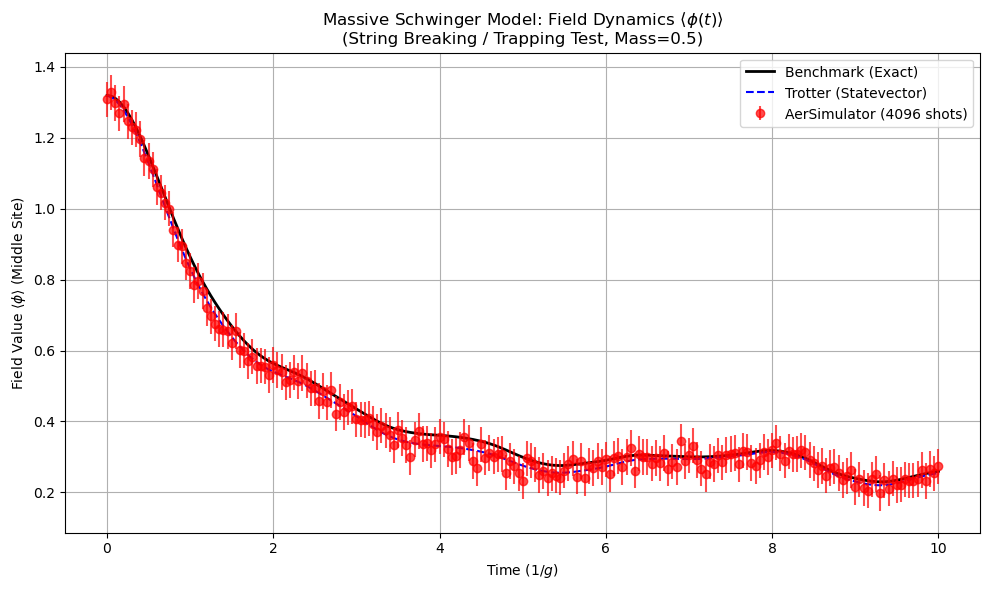

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm

# Qiskit Imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
from tqdm import tqdm

# ==========================================
# 1. PARAMETERS
# ==========================================
params = {
    "N_SITES": 5,              # 3 Spatial sites
    "N_QUBITS_PER_SITE": 2,    # 2 qubits = 4 Fock levels per site
    "N_LEVELS": 4,             # 2^2
    "A": 1.0,                  # Lattice spacing
    "G": 1.0,                  # Coupling
    "MASS": 0.5,               # Fermion mass (Strong coupling regime)
    "THETA": 0.0,              # Vacuum angle
    "DT": 0.05,                 # Time step
    "STEPS": 200,               # Number of Trotter steps
    "SHOTS": 4096              # Measurement shots
}

# Derived Constants
params["MU_SQ"] = (params["G"]**2) / np.pi
params["COS_COEFF"] = params["MASS"] * params["G"]

# ==========================================
# 2. OPERATOR CONSTRUCTION
# ==========================================

class SchwingerTrotter:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        self.n_q = p["N_QUBITS_PER_SITE"]
        
        # --- A. Local Matrix Operators (Fock Basis) ---
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        
        # Field Operators (Dimensionless w=1 basis)
        self.phi_mat = (1.0 / np.sqrt(2)) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(1/2) * (self.a_mat - self.adag_mat)
        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)
        
        # Cosine Term for Mass
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi_mat + self.p["THETA"] * self.id_mat
        self.cos_mat = 0.5 * (expm(1j * arg) + expm(-1j * arg))

        # --- B. Pauli String Conversion ---
        self.phi_op = SparsePauliOp.from_operator(Operator(self.phi_mat))
        self.pi2_op = SparsePauliOp.from_operator(Operator(self.pi2_mat))
        self.phi2_op = SparsePauliOp.from_operator(Operator(self.phi2_mat))
        self.cos_op = SparsePauliOp.from_operator(Operator(self.cos_mat))
        
        # --- C. Sparse Global Hamiltonian (For Benchmark) ---
        self.H_sparse = self._build_sparse_H()

    def _build_sparse_H(self):
        """Constructs exact sparse Hamiltonian for benchmarking."""
        N = self.p["N_SITES"]
        dim_full = self.dim ** N
        H = csr_matrix((dim_full, dim_full))
        
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]

        for i in range(N):
            # Kinetic & Potential
            H += c_kin * self._embed_sparse(self.pi2_mat, i)
            H += c_mass * self._embed_sparse(self.phi2_mat, i)
            H += c_sg * self._embed_sparse(self.cos_mat, i)
            # Gradient Self term
            n_neighbors = 1 if (i==0 or i==N-1) else 2
            H += c_grad * n_neighbors * self._embed_sparse(self.phi2_mat, i)

        # Gradient Cross terms
        for i in range(N-1):
            term = self._embed_two_site_sparse(self.phi_mat, self.phi_mat, i, i+1)
            H -= 2.0 * c_grad * term
            
        return H

    def _embed_sparse(self, op, site):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[site] = op
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_two_site_sparse(self, op1, op2, s1, s2):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_pauli(self, pauli_op, site):
        """
        FIXED: Embeds local PauliOp into N-site system matching np.kron order.
        Order: Site 0 (x) Site 1 (x) ... (x) Site N-1
        """
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[site] = pauli_op
        
        # Start with Site 0
        full = ops[0]
        # Tensor downwards to N-1
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def _embed_two_site_pauli(self, op1, op2, s1, s2):
        """FIXED: Embeds two-site PauliOp matching np.kron order."""
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        
        full = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def get_trotter_step_gate(self, dt):
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]
        
        # 1. Kinetic Layer
        kin_ops = []
        for i in range(self.p["N_SITES"]):
            kin_ops.append(self._embed_pauli(self.pi2_op, i))
        U_kin = PauliEvolutionGate(sum(kin_ops), time=dt * c_kin)
        
        # 2. Potential Layer
        pot_ops = []
        for i in range(self.p["N_SITES"]):
            n_neighbors = 1 if (i==0 or i==self.p["N_SITES"]-1) else 2
            term1 = self._embed_pauli(self.phi2_op, i)
            pot_ops.append(term1 * (c_mass + c_grad * n_neighbors))
            
            term2 = self._embed_pauli(self.cos_op, i)
            pot_ops.append(term2 * c_sg)
        U_pot = PauliEvolutionGate(sum(pot_ops), time=dt)
        
        # 3. Interaction Layer
        int_ops = []
        for i in range(self.p["N_SITES"]-1):
            int_ops.append(self._embed_two_site_pauli(self.phi_op, self.phi_op, i, i+1))
        U_int = PauliEvolutionGate(sum(int_ops), time=dt * (-2.0 * c_grad))
        
        qc_step = QuantumCircuit(self.p["N_SITES"] * self.n_q)
        qc_step.append(U_kin, range(qc_step.num_qubits))
        qc_step.append(U_pot, range(qc_step.num_qubits))
        qc_step.append(U_int, range(qc_step.num_qubits))
        
        return qc_step.to_gate(label="TrotterStep")

# ==========================================
# 3. QUANTUM SIMULATION UTILS
# ==========================================

def measure_expectation_aer(qc, observable, backend, shots):
    """Measures expectation value <psi|O|psi> using AerSimulator."""
    total_exp = 0.0
    for pauli, coeff in zip(observable.paulis, observable.coeffs):
        meas_qc = qc.copy()
        pauli_str = pauli.to_label()
        
        indices = []
        for i, char in enumerate(reversed(pauli_str)):
            if char == 'X':
                meas_qc.h(i)
                indices.append(i)
            elif char == 'Y':
                meas_qc.sdg(i)
                meas_qc.h(i)
                indices.append(i)
            elif char == 'Z':
                indices.append(i)
        
        if not indices:
            total_exp += coeff.real
            continue
            
        meas_qc.measure_all()
        job = backend.run(transpile(meas_qc, backend), shots=shots)
        counts = job.result().get_counts()
        
        term_val = 0
        for bitstring, count in counts.items():
            parity = 1
            for idx in indices:
                if bitstring[-(idx+1)] == '1':
                    parity *= -1
            term_val += parity * count
        total_exp += coeff.real * (term_val / shots)
        
    return total_exp

# ==========================================
# 4. MAIN SIMULATION
# ==========================================

def run_simulation():
    model = SchwingerTrotter(params)
    backend = AerSimulator()
    
    # --- Initial State ---
    alpha = 1.5
    disp_mat = expm(alpha * model.adag_mat - alpha * model.a_mat)
    vac = np.zeros(model.dim); vac[0] = 1.0
    excited = disp_mat @ vac
    
    # Construct psi_0 (Vacuum - Excited - Vacuum)
    mid_site = params["N_SITES"] // 2
    psi_0 = vac
    for i in range(1, params["N_SITES"]):
        if i == mid_site:
            psi_0 = np.kron(psi_0, excited)
        else:
            psi_0 = np.kron(psi_0, vac)
            
    # --- Observables ---
    obs_op = model._embed_pauli(model.phi_op, mid_site)
    
    times = np.arange(0, params["DT"] * (params["STEPS"]+1), params["DT"])
    res_bench = []
    res_trot = []
    res_aer = []
    
    print(f"Starting Simulation (Mass m0={params['MASS']})...")
    
    # 1. Benchmark (Exact)
    psi_t = psi_0.copy()
    print("Running Benchmark...")
    for _ in range(len(times)):
        val = psi_t.conj().T @ (model._embed_sparse(model.phi_mat, mid_site) @ psi_t)
        res_bench.append(val.real)
        psi_t = expm_multiply(-1j * model.H_sparse * params["DT"], psi_t)

    # 2. Trotter + Quantum
    print(f"Running Quantum Sim ({params['SHOTS']} shots)...")
    trotter_gate = model.get_trotter_step_gate(params["DT"])
    
    qc = QuantumCircuit(params["N_SITES"] * params["N_QUBITS_PER_SITE"])
    qc.initialize(psi_0, range(qc.num_qubits))
    
    for t_step in tqdm(range(len(times))):
        # Statevector (Ideal Trotter)
        sv = Statevector(qc)
        val_sv = sv.expectation_value(obs_op).real
        res_trot.append(val_sv)
        
        # Aer Measurement
        val_aer = measure_expectation_aer(qc, obs_op, backend, params["SHOTS"])
        res_aer.append(val_aer)
        
        if t_step < params["STEPS"]:
            qc.append(trotter_gate, range(qc.num_qubits))

    return times, res_bench, res_trot, res_aer

# ==========================================
# 5. PLOTTING
# ==========================================

def plot_results(times, bench, trot, aer):
    plt.figure(figsize=(10, 6))
    plt.plot(times, bench, 'k-', linewidth=2, label='Benchmark (Exact)')
    plt.plot(times, trot, 'b--', label='Trotter (Statevector)')
    plt.errorbar(times, aer, yerr=0.05, fmt='ro', label=f'AerSimulator ({params["SHOTS"]} shots)', alpha=0.7)
    
    plt.title(f"Massive Schwinger Model: Field Dynamics $\\langle \\phi(t) \\rangle$\n(String Breaking / Trapping Test, Mass={params['MASS']})")
    plt.xlabel("Time ($1/g$)")
    plt.ylabel("Field Value $\\langle \\phi \\rangle$ (Middle Site)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data = run_simulation()
    plot_results(*data)

Starting Spatiotemporal Sim (N=5, Steps=400)...
Running Benchmark...
Running AerSimulator (2000 shots)...


100%|██████████| 401/401 [18:00<00:00,  2.69s/it]


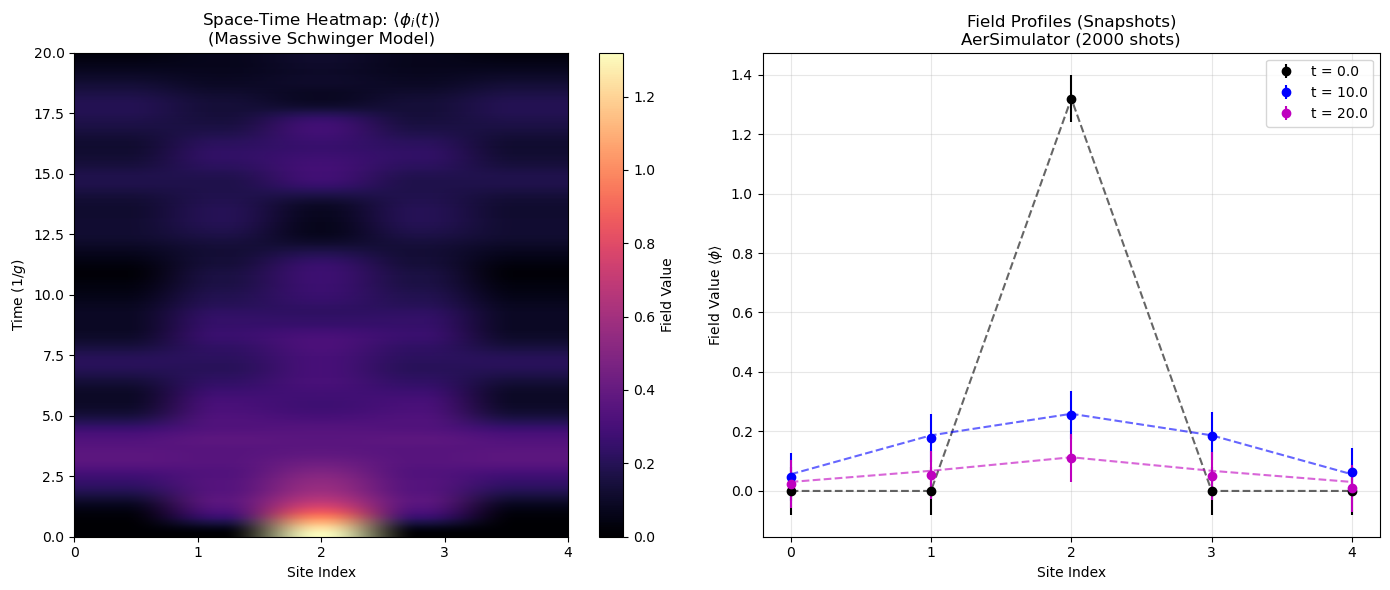

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm

# Qiskit Imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from tqdm import tqdm

# ==========================================
# 1. PARAMETERS
# ==========================================
params = {
    "N_SITES": 5,              # Increased to 5 for better Heatmap resolution
    "N_QUBITS_PER_SITE": 2,    # 2 qubits = 4 Fock levels per site
    "N_LEVELS": 4,             # 2^2
    "A": 1.0,                  # Lattice spacing
    "G": 1.0,                  # Coupling
    "MASS": 0.5,               # Mass parameter (Confining potential)
    "THETA": 0.0,              # Vacuum angle
    "DT": 0.05,                # Time step
    "STEPS": 400,               # Number of Trotter steps
    "SHOTS": 2000              # Measurement shots
}

# Derived Constants
params["MU_SQ"] = (params["G"]**2) / np.pi
params["COS_COEFF"] = params["MASS"] * params["G"]

# ==========================================
# 2. OPERATOR CONSTRUCTION
# ==========================================

class SchwingerTrotter:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        self.n_q = p["N_QUBITS_PER_SITE"]
        
        # --- A. Local Matrix Operators (Fock Basis) ---
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        
        # Field Operators (Dimensionless w=1 basis)
        self.phi_mat = (1.0 / np.sqrt(2)) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(1/2) * (self.a_mat - self.adag_mat)
        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)
        
        # Cosine Term for Mass
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi_mat + self.p["THETA"] * self.id_mat
        self.cos_mat = 0.5 * (expm(1j * arg) + expm(-1j * arg))

        # --- B. Pauli String Conversion ---
        self.phi_op = SparsePauliOp.from_operator(Operator(self.phi_mat))
        self.pi2_op = SparsePauliOp.from_operator(Operator(self.pi2_mat))
        self.phi2_op = SparsePauliOp.from_operator(Operator(self.phi2_mat))
        self.cos_op = SparsePauliOp.from_operator(Operator(self.cos_mat))
        
        # --- C. Sparse Global Hamiltonian (For Benchmark) ---
        self.H_sparse = self._build_sparse_H()

    def _build_sparse_H(self):
        """Constructs exact sparse Hamiltonian for benchmarking."""
        N = self.p["N_SITES"]
        dim_full = self.dim ** N
        H = csr_matrix((dim_full, dim_full))
        
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]

        for i in range(N):
            # Kinetic & Potential
            H += c_kin * self._embed_sparse(self.pi2_mat, i)
            H += c_mass * self._embed_sparse(self.phi2_mat, i)
            H += c_sg * self._embed_sparse(self.cos_mat, i)
            # Gradient Self term
            n_neighbors = 1 if (i==0 or i==N-1) else 2
            H += c_grad * n_neighbors * self._embed_sparse(self.phi2_mat, i)

        # Gradient Cross terms
        for i in range(N-1):
            term = self._embed_two_site_sparse(self.phi_mat, self.phi_mat, i, i+1)
            H -= 2.0 * c_grad * term
            
        return H

    def _embed_sparse(self, op, site):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[site] = op
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_two_site_sparse(self, op1, op2, s1, s2):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_pauli(self, pauli_op, site):
        """Embeds local PauliOp into N-site system matching np.kron order."""
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[site] = pauli_op
        
        # Tensor Order: ops[0] (x) ops[1] ... (x) ops[N-1]
        full = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def _embed_two_site_pauli(self, op1, op2, s1, s2):
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        
        full = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def get_trotter_step_gate(self, dt):
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]
        
        # 1. Kinetic Layer
        kin_ops = []
        for i in range(self.p["N_SITES"]):
            kin_ops.append(self._embed_pauli(self.pi2_op, i))
        U_kin = PauliEvolutionGate(sum(kin_ops), time=dt * c_kin)
        
        # 2. Potential Layer
        pot_ops = []
        for i in range(self.p["N_SITES"]):
            n_neighbors = 1 if (i==0 or i==self.p["N_SITES"]-1) else 2
            term1 = self._embed_pauli(self.phi2_op, i)
            pot_ops.append(term1 * (c_mass + c_grad * n_neighbors))
            
            term2 = self._embed_pauli(self.cos_op, i)
            pot_ops.append(term2 * c_sg)
        U_pot = PauliEvolutionGate(sum(pot_ops), time=dt)
        
        # 3. Interaction Layer
        int_ops = []
        for i in range(self.p["N_SITES"]-1):
            int_ops.append(self._embed_two_site_pauli(self.phi_op, self.phi_op, i, i+1))
        U_int = PauliEvolutionGate(sum(int_ops), time=dt * (-2.0 * c_grad))
        
        qc_step = QuantumCircuit(self.p["N_SITES"] * self.n_q)
        qc_step.append(U_kin, range(qc_step.num_qubits))
        qc_step.append(U_pot, range(qc_step.num_qubits))
        qc_step.append(U_int, range(qc_step.num_qubits))
        
        return qc_step.to_gate(label="TrotterStep")

# ==========================================
# 3. QUANTUM SIMULATION UTILS
# ==========================================

def measure_expectation_aer(qc, observable, backend, shots):
    """Measures expectation value <psi|O|psi> using AerSimulator."""
    total_exp = 0.0
    for pauli, coeff in zip(observable.paulis, observable.coeffs):
        meas_qc = qc.copy()
        pauli_str = pauli.to_label()
        
        indices = []
        for i, char in enumerate(reversed(pauli_str)):
            if char == 'X':
                meas_qc.h(i)
                indices.append(i)
            elif char == 'Y':
                meas_qc.sdg(i)
                meas_qc.h(i)
                indices.append(i)
            elif char == 'Z':
                indices.append(i)
        
        if not indices:
            total_exp += coeff.real
            continue
            
        meas_qc.measure_all()
        job = backend.run(transpile(meas_qc, backend), shots=shots)
        counts = job.result().get_counts()
        
        term_val = 0
        for bitstring, count in counts.items():
            parity = 1
            for idx in indices:
                if bitstring[-(idx+1)] == '1':
                    parity *= -1
            term_val += parity * count
        total_exp += coeff.real * (term_val / shots)
        
    return total_exp

# ==========================================
# 4. MAIN SIMULATION LOOP (SPATIOTEMPORAL)
# ==========================================

def run_spatiotemporal_sim():
    model = SchwingerTrotter(params)
    backend = AerSimulator()
    
    # --- Initial State: String Exictation at Center ---
    alpha = 1.5
    disp_mat = expm(alpha * model.adag_mat - alpha * model.a_mat)
    vac = np.zeros(model.dim); vac[0] = 1.0
    excited = disp_mat @ vac
    
    # Construct psi_0 (Vacuum...Excited...Vacuum)
    mid_site = params["N_SITES"] // 2
    psi_0 = vac
    for i in range(1, params["N_SITES"]):
        if i == mid_site:
            psi_0 = np.kron(psi_0, excited)
        else:
            psi_0 = np.kron(psi_0, vac)
            
    # --- Simulation Storage ---
    times = np.arange(0, params["DT"] * (params["STEPS"]+1), params["DT"])
    
    # Arrays to store Field(time, site)
    field_exact = np.zeros((len(times), params["N_SITES"]))
    field_aer = np.zeros((len(times), params["N_SITES"]))
    
    # Pre-compute observables for all sites
    site_obs = [model._embed_pauli(model.phi_op, i) for i in range(params["N_SITES"])]
    
    print(f"Starting Spatiotemporal Sim (N={params['N_SITES']}, Steps={params['STEPS']})...")
    
    # 1. Exact Benchmark
    print("Running Benchmark...")
    psi_t = psi_0.copy()
    for t_idx in range(len(times)):
        for i in range(params["N_SITES"]):
            op = model._embed_sparse(model.phi_mat, i)
            val = psi_t.conj().T @ (op @ psi_t)
            field_exact[t_idx, i] = val.real
        psi_t = expm_multiply(-1j * model.H_sparse * params["DT"], psi_t)

    # 2. Quantum (Aer)
    # Setup EstimatorV2
    backend_sim = AerSimulator()
    estimator = AerEstimator()
    estimator.options.default_shots = params["SHOTS"]

    print(f"Running AerSimulator ({params['SHOTS']} shots)...")
    trotter_gate = model.get_trotter_step_gate(params["DT"])
    
    qc = QuantumCircuit(params["N_SITES"] * params["N_QUBITS_PER_SITE"])
    qc.initialize(psi_0, range(qc.num_qubits))
    
    for t_idx in tqdm(range(len(times))):
        # 1. Transpile to ISA circuit (Strictly required for EstimatorV2)
        isa_qc = transpile(qc, backend_sim)
        
        # 2. Create a PUB (Primitive Unified Bloc)
        # We batch the single circuit with ALL site observables at once.
        # site_obs is assumed to be a list of full-system SparsePauliOps.
        pub = (isa_qc, site_obs)
        
        # 3. Run Estimator
        job = estimator.run([pub])
        result = job.result()
        
        # 4. Extract batched results
        # result[0] corresponds to our single PUB. 
        # .data.evs contains the array of expectation values for all observables in site_obs.
        field_aer[t_idx, :] = result[0].data.evs
        
        if t_idx < params["STEPS"]:
            qc.append(trotter_gate, range(qc.num_qubits))

    return times, field_exact, field_aer

# ==========================================
# 5. PLOTTING
# ==========================================

def plot_heatmap_and_profiles(times, field_exact, field_aer):
    fig = plt.figure(figsize=(14, 6))
    
    # Plot 1: Heatmap (Exact Dynamics)
    ax1 = fig.add_subplot(1, 2, 1)
    # Using field_exact for the smooth heatmap
    im = ax1.imshow(field_exact, aspect='auto', origin='lower', cmap='magma',
                   extent=[0, params["N_SITES"]-1, times[0], times[-1]])
    ax1.set_title("Space-Time Heatmap: $\\langle \\phi_i(t) \\rangle$\n(Massive Schwinger Model)")
    ax1.set_xlabel("Site Index")
    ax1.set_ylabel("Time ($1/g$)")
    ax1.set_xticks(range(params["N_SITES"]))
    plt.colorbar(im, ax=ax1, label="Field Value")

    # Plot 2: Field Profiles (Snapshots)
    ax2 = fig.add_subplot(1, 2, 2)
    
    # Select 3 snapshots
    indices = [0, len(times)//2, len(times)-1]
    colors = ['k', 'b', 'm']
    
    for idx, color in zip(indices, colors):
        t_val = times[idx]
        # Benchmark line
        ax2.plot(range(params["N_SITES"]), field_exact[idx, :], 
                 linestyle='--', color=color, alpha=0.6)
        # Aer Dots
        ax2.errorbar(range(params["N_SITES"]), field_aer[idx, :], 
                     yerr=0.08, fmt='o', color=color, 
                     label=f't = {t_val:.1f}')
        
    ax2.set_title(f"Field Profiles (Snapshots)\nAerSimulator ({params['SHOTS']} shots)")
    ax2.set_xlabel("Site Index")
    ax2.set_ylabel("Field Value $\\langle \\phi \\rangle$")
    ax2.set_xticks(range(params["N_SITES"]))
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data = run_spatiotemporal_sim()
    plot_heatmap_and_profiles(*data)

Starting Spatiotemporal Sim (N=5, Steps=400)...
Running Benchmark...
Running AerSimulator (2000 shots)...


100%|██████████| 401/401 [21:21<00:00,  3.20s/it]


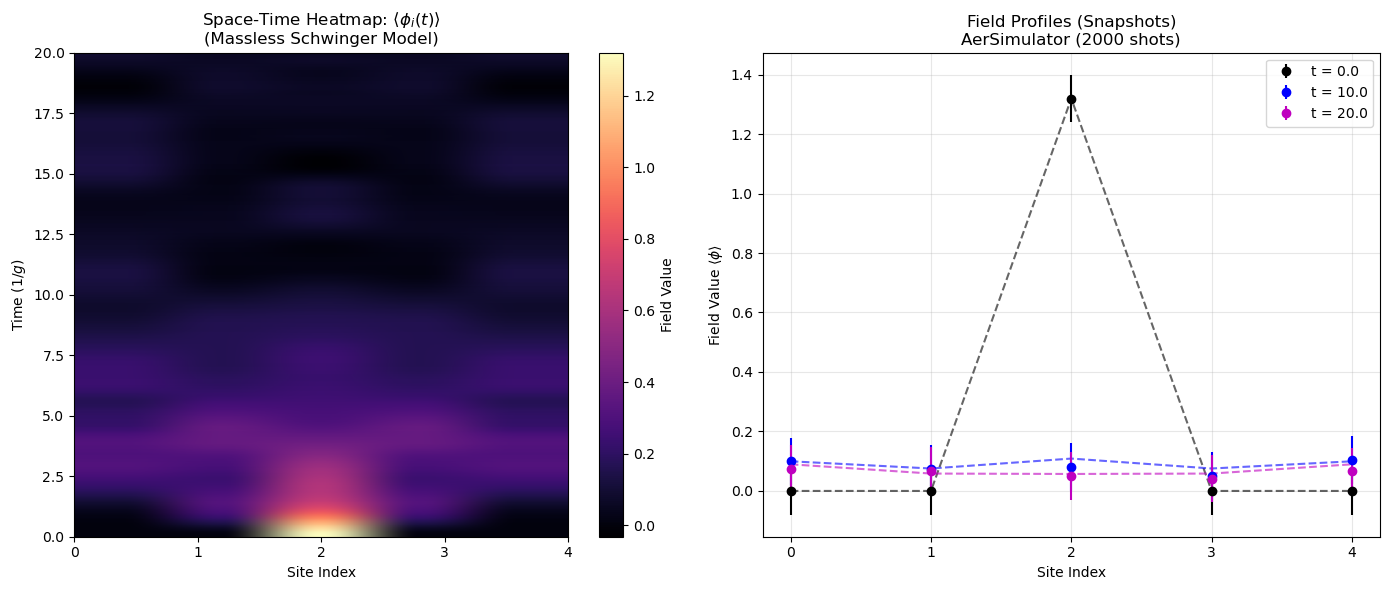

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm

# Qiskit Imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from tqdm import tqdm

# ==========================================
# 1. PARAMETERS
# ==========================================
params = {
    "N_SITES": 5,              # Increased to 5 for better Heatmap resolution
    "N_QUBITS_PER_SITE": 2,    # 2 qubits = 4 Fock levels per site
    "N_LEVELS": 4,             # 2^2
    "A": 1.0,                  # Lattice spacing
    "G": 1.0,                  # Coupling
    "MASS": 0.0,               # Mass parameter (Confining potential)
    "THETA": 0.0,              # Vacuum angle
    "DT": 0.05,                # Time step
    "STEPS": 400,               # Number of Trotter steps
    "SHOTS": 2000              # Measurement shots
}

# Derived Constants
params["MU_SQ"] = (params["G"]**2) / np.pi
params["COS_COEFF"] = params["MASS"] * params["G"]

# ==========================================
# 2. OPERATOR CONSTRUCTION
# ==========================================

class SchwingerTrotter:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        self.n_q = p["N_QUBITS_PER_SITE"]
        
        # --- A. Local Matrix Operators (Fock Basis) ---
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        
        # Field Operators (Dimensionless w=1 basis)
        self.phi_mat = (1.0 / np.sqrt(2)) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(1/2) * (self.a_mat - self.adag_mat)
        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)
        
        # Cosine Term for Mass
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi_mat + self.p["THETA"] * self.id_mat
        self.cos_mat = 0.5 * (expm(1j * arg) + expm(-1j * arg))

        # --- B. Pauli String Conversion ---
        self.phi_op = SparsePauliOp.from_operator(Operator(self.phi_mat))
        self.pi2_op = SparsePauliOp.from_operator(Operator(self.pi2_mat))
        self.phi2_op = SparsePauliOp.from_operator(Operator(self.phi2_mat))
        self.cos_op = SparsePauliOp.from_operator(Operator(self.cos_mat))
        
        # --- C. Sparse Global Hamiltonian (For Benchmark) ---
        self.H_sparse = self._build_sparse_H()

    def _build_sparse_H(self):
        """Constructs exact sparse Hamiltonian for benchmarking."""
        N = self.p["N_SITES"]
        dim_full = self.dim ** N
        H = csr_matrix((dim_full, dim_full))
        
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]

        for i in range(N):
            # Kinetic & Potential
            H += c_kin * self._embed_sparse(self.pi2_mat, i)
            H += c_mass * self._embed_sparse(self.phi2_mat, i)
            H += c_sg * self._embed_sparse(self.cos_mat, i)
            # Gradient Self term
            n_neighbors = 1 if (i==0 or i==N-1) else 2
            H += c_grad * n_neighbors * self._embed_sparse(self.phi2_mat, i)

        # Gradient Cross terms
        for i in range(N-1):
            term = self._embed_two_site_sparse(self.phi_mat, self.phi_mat, i, i+1)
            H -= 2.0 * c_grad * term
            
        return H

    def _embed_sparse(self, op, site):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[site] = op
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_two_site_sparse(self, op1, op2, s1, s2):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_pauli(self, pauli_op, site):
        """Embeds local PauliOp into N-site system matching np.kron order."""
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[site] = pauli_op
        
        # Tensor Order: ops[0] (x) ops[1] ... (x) ops[N-1]
        full = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def _embed_two_site_pauli(self, op1, op2, s1, s2):
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        
        full = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def get_trotter_step_gate(self, dt):
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]
        
        # 1. Kinetic Layer
        kin_ops = []
        for i in range(self.p["N_SITES"]):
            kin_ops.append(self._embed_pauli(self.pi2_op, i))
        U_kin = PauliEvolutionGate(sum(kin_ops), time=dt * c_kin)
        
        # 2. Potential Layer
        pot_ops = []
        for i in range(self.p["N_SITES"]):
            n_neighbors = 1 if (i==0 or i==self.p["N_SITES"]-1) else 2
            term1 = self._embed_pauli(self.phi2_op, i)
            pot_ops.append(term1 * (c_mass + c_grad * n_neighbors))
            
            term2 = self._embed_pauli(self.cos_op, i)
            pot_ops.append(term2 * c_sg)
        U_pot = PauliEvolutionGate(sum(pot_ops), time=dt)
        
        # 3. Interaction Layer
        int_ops = []
        for i in range(self.p["N_SITES"]-1):
            int_ops.append(self._embed_two_site_pauli(self.phi_op, self.phi_op, i, i+1))
        U_int = PauliEvolutionGate(sum(int_ops), time=dt * (-2.0 * c_grad))
        
        qc_step = QuantumCircuit(self.p["N_SITES"] * self.n_q)
        qc_step.append(U_kin, range(qc_step.num_qubits))
        qc_step.append(U_pot, range(qc_step.num_qubits))
        qc_step.append(U_int, range(qc_step.num_qubits))
        
        return qc_step.to_gate(label="TrotterStep")

# ==========================================
# 3. QUANTUM SIMULATION UTILS
# ==========================================

def measure_expectation_aer(qc, observable, backend, shots):
    """Measures expectation value <psi|O|psi> using AerSimulator."""
    total_exp = 0.0
    for pauli, coeff in zip(observable.paulis, observable.coeffs):
        meas_qc = qc.copy()
        pauli_str = pauli.to_label()
        
        indices = []
        for i, char in enumerate(reversed(pauli_str)):
            if char == 'X':
                meas_qc.h(i)
                indices.append(i)
            elif char == 'Y':
                meas_qc.sdg(i)
                meas_qc.h(i)
                indices.append(i)
            elif char == 'Z':
                indices.append(i)
        
        if not indices:
            total_exp += coeff.real
            continue
            
        meas_qc.measure_all()
        job = backend.run(transpile(meas_qc, backend), shots=shots)
        counts = job.result().get_counts()
        
        term_val = 0
        for bitstring, count in counts.items():
            parity = 1
            for idx in indices:
                if bitstring[-(idx+1)] == '1':
                    parity *= -1
            term_val += parity * count
        total_exp += coeff.real * (term_val / shots)
        
    return total_exp

# ==========================================
# 4. MAIN SIMULATION LOOP (SPATIOTEMPORAL)
# ==========================================

def run_spatiotemporal_sim():
    model = SchwingerTrotter(params)
    backend = AerSimulator()
    
    # --- Initial State: String Exictation at Center ---
    alpha = 1.5
    disp_mat = expm(alpha * model.adag_mat - alpha * model.a_mat)
    vac = np.zeros(model.dim); vac[0] = 1.0
    excited = disp_mat @ vac
    
    # Construct psi_0 (Vacuum...Excited...Vacuum)
    mid_site = params["N_SITES"] // 2
    psi_0 = vac
    for i in range(1, params["N_SITES"]):
        if i == mid_site:
            psi_0 = np.kron(psi_0, excited)
        else:
            psi_0 = np.kron(psi_0, vac)
            
    # --- Simulation Storage ---
    times = np.arange(0, params["DT"] * (params["STEPS"]+1), params["DT"])
    
    # Arrays to store Field(time, site)
    field_exact = np.zeros((len(times), params["N_SITES"]))
    field_aer = np.zeros((len(times), params["N_SITES"]))
    
    # Pre-compute observables for all sites
    site_obs = [model._embed_pauli(model.phi_op, i) for i in range(params["N_SITES"])]
    
    print(f"Starting Spatiotemporal Sim (N={params['N_SITES']}, Steps={params['STEPS']})...")
    
    # 1. Exact Benchmark
    print("Running Benchmark...")
    psi_t = psi_0.copy()
    for t_idx in range(len(times)):
        for i in range(params["N_SITES"]):
            op = model._embed_sparse(model.phi_mat, i)
            val = psi_t.conj().T @ (op @ psi_t)
            field_exact[t_idx, i] = val.real
        psi_t = expm_multiply(-1j * model.H_sparse * params["DT"], psi_t)

    # 2. Quantum (Aer)
    # Setup EstimatorV2
    backend_sim = AerSimulator()
    estimator = AerEstimator()
    estimator.options.default_shots = params["SHOTS"]

    print(f"Running AerSimulator ({params['SHOTS']} shots)...")
    trotter_gate = model.get_trotter_step_gate(params["DT"])
    
    qc = QuantumCircuit(params["N_SITES"] * params["N_QUBITS_PER_SITE"])
    qc.initialize(psi_0, range(qc.num_qubits))
    
    for t_idx in tqdm(range(len(times))):
        # 1. Transpile to ISA circuit (Strictly required for EstimatorV2)
        isa_qc = transpile(qc, backend_sim)
        
        # 2. Create a PUB (Primitive Unified Bloc)
        # We batch the single circuit with ALL site observables at once.
        # site_obs is assumed to be a list of full-system SparsePauliOps.
        pub = (isa_qc, site_obs)
        
        # 3. Run Estimator
        job = estimator.run([pub])
        result = job.result()
        
        # 4. Extract batched results
        # result[0] corresponds to our single PUB. 
        # .data.evs contains the array of expectation values for all observables in site_obs.
        field_aer[t_idx, :] = result[0].data.evs
        
        if t_idx < params["STEPS"]:
            qc.append(trotter_gate, range(qc.num_qubits))

    return times, field_exact, field_aer

# ==========================================
# 5. PLOTTING
# ==========================================

def plot_heatmap_and_profiles(times, field_exact, field_aer):
    fig = plt.figure(figsize=(14, 6))
    
    # Plot 1: Heatmap (Exact Dynamics)
    ax1 = fig.add_subplot(1, 2, 1)
    # Using field_exact for the smooth heatmap
    im = ax1.imshow(field_exact, aspect='auto', origin='lower', cmap='magma',
                   extent=[0, params["N_SITES"]-1, times[0], times[-1]])
    ax1.set_title("Space-Time Heatmap: $\\langle \\phi_i(t) \\rangle$\n(Massless Schwinger Model)")
    ax1.set_xlabel("Site Index")
    ax1.set_ylabel("Time ($1/g$)")
    ax1.set_xticks(range(params["N_SITES"]))
    plt.colorbar(im, ax=ax1, label="Field Value")

    # Plot 2: Field Profiles (Snapshots)
    ax2 = fig.add_subplot(1, 2, 2)
    
    # Select 3 snapshots
    indices = [0, len(times)//2, len(times)-1]
    colors = ['k', 'b', 'm']
    
    for idx, color in zip(indices, colors):
        t_val = times[idx]
        # Benchmark line
        ax2.plot(range(params["N_SITES"]), field_exact[idx, :], 
                 linestyle='--', color=color, alpha=0.6)
        # Aer Dots
        ax2.errorbar(range(params["N_SITES"]), field_aer[idx, :], 
                     yerr=0.08, fmt='o', color=color, 
                     label=f't = {t_val:.1f}')
        
    ax2.set_title(f"Field Profiles (Snapshots)\nAerSimulator ({params['SHOTS']} shots)")
    ax2.set_xlabel("Site Index")
    ax2.set_ylabel("Field Value $\\langle \\phi \\rangle$")
    ax2.set_xticks(range(params["N_SITES"]))
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data = run_spatiotemporal_sim()
    plot_heatmap_and_profiles(*data)

Starting Simulation (Mass m0=0.0)...
Running Benchmark...
Running Quantum Sim (2000 shots)...


100%|██████████| 401/401 [42:53<00:00,  6.42s/it]


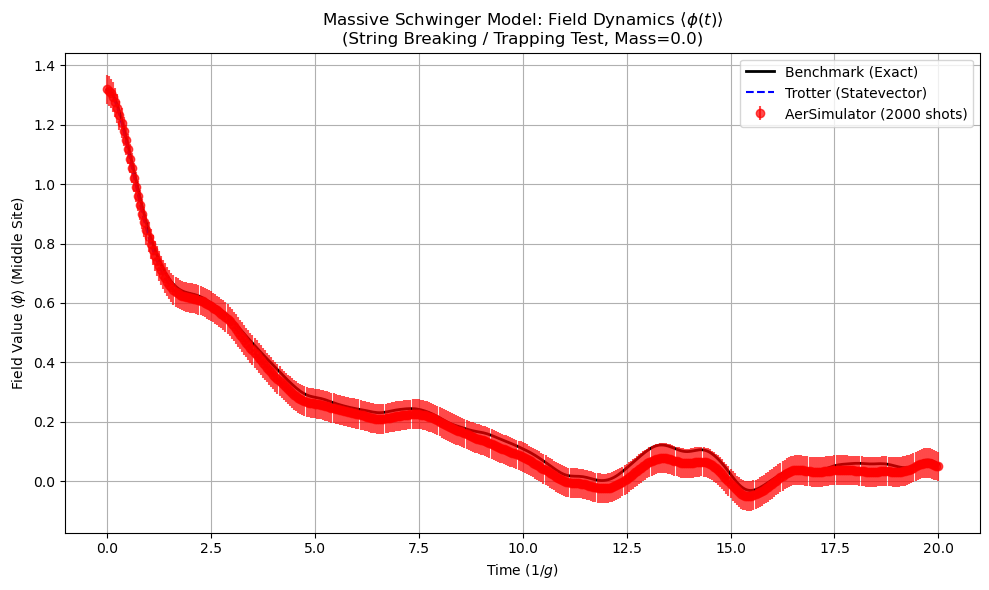

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm

# Qiskit Imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
# IMPORT ADDED: EstimatorV2
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from tqdm import tqdm

# ==========================================
# 1. PARAMETERS
# ==========================================
params = {
    "N_SITES": 5,              # 3 Spatial sites
    "N_QUBITS_PER_SITE": 2,    # 2 qubits = 4 Fock levels per site
    "N_LEVELS": 4,             # 2^2
    "A": 1.0,                  # Lattice spacing
    "G": 1.0,                  # Coupling
    "MASS": 0.0,               # Fermion mass (Strong coupling regime)
    "THETA": 0.0,              # Vacuum angle
    "DT": 0.05,                 # Time step
    "STEPS": 400,               # Number of Trotter steps
    "SHOTS": 2000              # Measurement shots
}

# Derived Constants
params["MU_SQ"] = (params["G"]**2) / np.pi
params["COS_COEFF"] = params["MASS"] * params["G"]

# ==========================================
# 2. OPERATOR CONSTRUCTION
# ==========================================

class SchwingerTrotter:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        self.n_q = p["N_QUBITS_PER_SITE"]
        
        # --- A. Local Matrix Operators (Fock Basis) ---
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        
        # Field Operators (Dimensionless w=1 basis)
        self.phi_mat = (1.0 / np.sqrt(2)) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(1/2) * (self.a_mat - self.adag_mat)
        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)
        
        # Cosine Term for Mass
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi_mat + self.p["THETA"] * self.id_mat
        self.cos_mat = 0.5 * (expm(1j * arg) + expm(-1j * arg))

        # --- B. Pauli String Conversion ---
        self.phi_op = SparsePauliOp.from_operator(Operator(self.phi_mat))
        self.pi2_op = SparsePauliOp.from_operator(Operator(self.pi2_mat))
        self.phi2_op = SparsePauliOp.from_operator(Operator(self.phi2_mat))
        self.cos_op = SparsePauliOp.from_operator(Operator(self.cos_mat))
        
        # --- C. Sparse Global Hamiltonian (For Benchmark) ---
        self.H_sparse = self._build_sparse_H()

    def _build_sparse_H(self):
        """Constructs exact sparse Hamiltonian for benchmarking."""
        N = self.p["N_SITES"]
        dim_full = self.dim ** N
        H = csr_matrix((dim_full, dim_full))
        
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]

        for i in range(N):
            # Kinetic & Potential
            H += c_kin * self._embed_sparse(self.pi2_mat, i)
            H += c_mass * self._embed_sparse(self.phi2_mat, i)
            H += c_sg * self._embed_sparse(self.cos_mat, i)
            # Gradient Self term
            n_neighbors = 1 if (i==0 or i==N-1) else 2
            H += c_grad * n_neighbors * self._embed_sparse(self.phi2_mat, i)

        # Gradient Cross terms
        for i in range(N-1):
            term = self._embed_two_site_sparse(self.phi_mat, self.phi_mat, i, i+1)
            H -= 2.0 * c_grad * term
            
        return H

    def _embed_sparse(self, op, site):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[site] = op
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_two_site_sparse(self, op1, op2, s1, s2):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_pauli(self, pauli_op, site):
        """
        FIXED: Embeds local PauliOp into N-site system matching np.kron order.
        Order: Site 0 (x) Site 1 (x) ... (x) Site N-1
        """
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[site] = pauli_op
        
        # Start with Site 0
        full = ops[0]
        # Tensor downwards to N-1
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def _embed_two_site_pauli(self, op1, op2, s1, s2):
        """FIXED: Embeds two-site PauliOp matching np.kron order."""
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        
        full = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def get_trotter_step_gate(self, dt):
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]
        
        # 1. Kinetic Layer
        kin_ops = []
        for i in range(self.p["N_SITES"]):
            kin_ops.append(self._embed_pauli(self.pi2_op, i))
        U_kin = PauliEvolutionGate(sum(kin_ops), time=dt * c_kin)
        
        # 2. Potential Layer
        pot_ops = []
        for i in range(self.p["N_SITES"]):
            n_neighbors = 1 if (i==0 or i==self.p["N_SITES"]-1) else 2
            term1 = self._embed_pauli(self.phi2_op, i)
            pot_ops.append(term1 * (c_mass + c_grad * n_neighbors))
            
            term2 = self._embed_pauli(self.cos_op, i)
            pot_ops.append(term2 * c_sg)
        U_pot = PauliEvolutionGate(sum(pot_ops), time=dt)
        
        # 3. Interaction Layer
        int_ops = []
        for i in range(self.p["N_SITES"]-1):
            int_ops.append(self._embed_two_site_pauli(self.phi_op, self.phi_op, i, i+1))
        U_int = PauliEvolutionGate(sum(int_ops), time=dt * (-2.0 * c_grad))
        
        qc_step = QuantumCircuit(self.p["N_SITES"] * self.n_q)
        qc_step.append(U_kin, range(qc_step.num_qubits))
        qc_step.append(U_pot, range(qc_step.num_qubits))
        qc_step.append(U_int, range(qc_step.num_qubits))
        
        return qc_step.to_gate(label="TrotterStep")

# ==========================================
# 4. MAIN SIMULATION
# ==========================================

def run_simulation():
    model = SchwingerTrotter(params)
    
    # --- Setup EstimatorV2 ---
    # We keep AerSimulator for transpilation
    backend = AerSimulator()
    estimator = AerEstimator()
    # FIX: Options class in qiskit-aer is strict. We must set default_shots
    # as an attribute after initialization, NOT in the constructor.
    estimator.options.default_shots = params["SHOTS"]
    
    # --- Initial State ---
    alpha = 1.5
    disp_mat = expm(alpha * model.adag_mat - alpha * model.a_mat)
    vac = np.zeros(model.dim); vac[0] = 1.0
    excited = disp_mat @ vac
    
    # Construct psi_0 (Vacuum - Excited - Vacuum)
    mid_site = params["N_SITES"] // 2
    psi_0 = vac
    for i in range(1, params["N_SITES"]):
        if i == mid_site:
            psi_0 = np.kron(psi_0, excited)
        else:
            psi_0 = np.kron(psi_0, vac)
            
    # --- Observables ---
    obs_op = model._embed_pauli(model.phi_op, mid_site)
    
    times = np.arange(0, params["DT"] * (params["STEPS"]+1), params["DT"])
    res_bench = []
    res_trot = []
    res_aer = []
    
    print(f"Starting Simulation (Mass m0={params['MASS']})...")
    
    # 1. Benchmark (Exact)
    psi_t = psi_0.copy()
    print("Running Benchmark...")
    for _ in range(len(times)):
        val = psi_t.conj().T @ (model._embed_sparse(model.phi_mat, mid_site) @ psi_t)
        res_bench.append(val.real)
        psi_t = expm_multiply(-1j * model.H_sparse * params["DT"], psi_t)

    # 2. Trotter + Quantum
    print(f"Running Quantum Sim ({params['SHOTS']} shots)...")
    trotter_gate = model.get_trotter_step_gate(params["DT"])
    
    qc = QuantumCircuit(params["N_SITES"] * params["N_QUBITS_PER_SITE"])
    qc.initialize(psi_0, range(qc.num_qubits))
    
    for t_step in tqdm(range(len(times))):
        # Statevector (Ideal Trotter)
        sv = Statevector(qc)
        val_sv = sv.expectation_value(obs_op).real
        res_trot.append(val_sv)
        
        # --- Aer EstimatorV2 Execution ---
        # 1. Transpile current circuit to ISA (Required by V2)
        isa_qc = transpile(qc, backend)
        
        # 2. Create PUB (Primitive Unified Bloc): (Circuit, [Observables])
        pub = (isa_qc, [obs_op])
        
        # 3. Run Estimator
        job = estimator.run([pub])
        result = job.result()
        
        # 4. Extract result [0] -> PUB 0, .data.evs -> Expectation Values
        val_aer = result[0].data.evs[0]
        res_aer.append(val_aer)
        
        if t_step < params["STEPS"]:
            qc.append(trotter_gate, range(qc.num_qubits))

    return times, res_bench, res_trot, res_aer

# ==========================================
# 5. PLOTTING
# ==========================================

def plot_results(times, bench, trot, aer):
    plt.figure(figsize=(10, 6))
    plt.plot(times, bench, 'k-', linewidth=2, label='Benchmark (Exact)')
    plt.plot(times, trot, 'b--', label='Trotter (Statevector)')
    plt.errorbar(times, aer, yerr=0.05, fmt='ro', label=f'AerSimulator ({params["SHOTS"]} shots)', alpha=0.7)
    
    plt.title(f"Massive Schwinger Model: Field Dynamics $\\langle \\phi(t) \\rangle$\n(String Breaking / Trapping Test, Mass={params['MASS']})")
    plt.xlabel("Time ($1/g$)")
    plt.ylabel("Field Value $\\langle \\phi \\rangle$ (Middle Site)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data = run_simulation()
    plot_results(*data)

Starting Simulation (Mass m0=0.5)...
Running Benchmark...
Running Quantum Sim (4096 shots)...


100%|██████████| 201/201 [11:40<00:00,  3.49s/it]


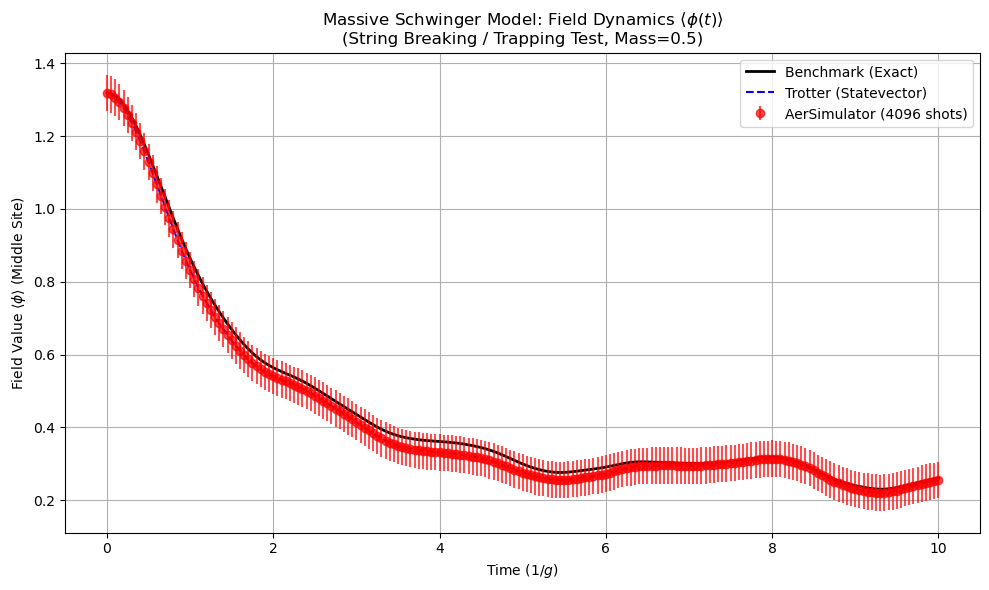

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm

# Qiskit Imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
# IMPORT ADDED: EstimatorV2
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from tqdm import tqdm

# ==========================================
# 1. PARAMETERS
# ==========================================
params = {
    "N_SITES": 5,              # 3 Spatial sites
    "N_QUBITS_PER_SITE": 2,    # 2 qubits = 4 Fock levels per site
    "N_LEVELS": 4,             # 2^2
    "A": 1.0,                  # Lattice spacing
    "G": 1.0,                  # Coupling
    "MASS": 0.5,               # Fermion mass (Strong coupling regime)
    "THETA": 0.0,              # Vacuum angle
    "DT": 0.05,                 # Time step
    "STEPS": 200,               # Number of Trotter steps
    "SHOTS": 4096              # Measurement shots
}

# Derived Constants
params["MU_SQ"] = (params["G"]**2) / np.pi
params["COS_COEFF"] = params["MASS"] * params["G"]

# ==========================================
# 2. OPERATOR CONSTRUCTION
# ==========================================

class SchwingerTrotter:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        self.n_q = p["N_QUBITS_PER_SITE"]
        
        # --- A. Local Matrix Operators (Fock Basis) ---
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        
        # Field Operators (Dimensionless w=1 basis)
        self.phi_mat = (1.0 / np.sqrt(2)) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(1/2) * (self.a_mat - self.adag_mat)
        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)
        
        # Cosine Term for Mass
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi_mat + self.p["THETA"] * self.id_mat
        self.cos_mat = 0.5 * (expm(1j * arg) + expm(-1j * arg))

        # --- B. Pauli String Conversion ---
        self.phi_op = SparsePauliOp.from_operator(Operator(self.phi_mat))
        self.pi2_op = SparsePauliOp.from_operator(Operator(self.pi2_mat))
        self.phi2_op = SparsePauliOp.from_operator(Operator(self.phi2_mat))
        self.cos_op = SparsePauliOp.from_operator(Operator(self.cos_mat))
        
        # --- C. Sparse Global Hamiltonian (For Benchmark) ---
        self.H_sparse = self._build_sparse_H()

    def _build_sparse_H(self):
        """Constructs exact sparse Hamiltonian for benchmarking."""
        N = self.p["N_SITES"]
        dim_full = self.dim ** N
        H = csr_matrix((dim_full, dim_full))
        
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]

        for i in range(N):
            # Kinetic & Potential
            H += c_kin * self._embed_sparse(self.pi2_mat, i)
            H += c_mass * self._embed_sparse(self.phi2_mat, i)
            H += c_sg * self._embed_sparse(self.cos_mat, i)
            # Gradient Self term
            n_neighbors = 1 if (i==0 or i==N-1) else 2
            H += c_grad * n_neighbors * self._embed_sparse(self.phi2_mat, i)

        # Gradient Cross terms
        for i in range(N-1):
            term = self._embed_two_site_sparse(self.phi_mat, self.phi_mat, i, i+1)
            H -= 2.0 * c_grad * term
            
        return H

    def _embed_sparse(self, op, site):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[site] = op
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_two_site_sparse(self, op1, op2, s1, s2):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_pauli(self, pauli_op, site):
        """
        FIXED: Embeds local PauliOp into N-site system matching np.kron order.
        Order: Site 0 (x) Site 1 (x) ... (x) Site N-1
        """
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[site] = pauli_op
        
        # Start with Site 0
        full = ops[0]
        # Tensor downwards to N-1
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def _embed_two_site_pauli(self, op1, op2, s1, s2):
        """FIXED: Embeds two-site PauliOp matching np.kron order."""
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        
        full = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def get_trotter_step_gate(self, dt):
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]
        
        # 1. Kinetic Layer
        kin_ops = []
        for i in range(self.p["N_SITES"]):
            kin_ops.append(self._embed_pauli(self.pi2_op, i))
        U_kin = PauliEvolutionGate(sum(kin_ops), time=dt * c_kin)
        
        # 2. Potential Layer
        pot_ops = []
        for i in range(self.p["N_SITES"]):
            n_neighbors = 1 if (i==0 or i==self.p["N_SITES"]-1) else 2
            term1 = self._embed_pauli(self.phi2_op, i)
            pot_ops.append(term1 * (c_mass + c_grad * n_neighbors))
            
            term2 = self._embed_pauli(self.cos_op, i)
            pot_ops.append(term2 * c_sg)
        U_pot = PauliEvolutionGate(sum(pot_ops), time=dt)
        
        # 3. Interaction Layer
        int_ops = []
        for i in range(self.p["N_SITES"]-1):
            int_ops.append(self._embed_two_site_pauli(self.phi_op, self.phi_op, i, i+1))
        U_int = PauliEvolutionGate(sum(int_ops), time=dt * (-2.0 * c_grad))
        
        qc_step = QuantumCircuit(self.p["N_SITES"] * self.n_q)
        qc_step.append(U_kin, range(qc_step.num_qubits))
        qc_step.append(U_pot, range(qc_step.num_qubits))
        qc_step.append(U_int, range(qc_step.num_qubits))
        
        return qc_step.to_gate(label="TrotterStep")

# ==========================================
# 4. MAIN SIMULATION
# ==========================================

def run_simulation():
    model = SchwingerTrotter(params)
    
    # --- Setup EstimatorV2 ---
    # We keep AerSimulator for transpilation
    backend = AerSimulator()
    estimator = AerEstimator()
    # FIX: Options class in qiskit-aer is strict. We must set default_shots
    # as an attribute after initialization, NOT in the constructor.
    estimator.options.default_shots = params["SHOTS"]
    
    # --- Initial State ---
    alpha = 1.5
    disp_mat = expm(alpha * model.adag_mat - alpha * model.a_mat)
    vac = np.zeros(model.dim); vac[0] = 1.0
    excited = disp_mat @ vac
    
    # Construct psi_0 (Vacuum - Excited - Vacuum)
    mid_site = params["N_SITES"] // 2
    psi_0 = vac
    for i in range(1, params["N_SITES"]):
        if i == mid_site:
            psi_0 = np.kron(psi_0, excited)
        else:
            psi_0 = np.kron(psi_0, vac)
            
    # --- Observables ---
    obs_op = model._embed_pauli(model.phi_op, mid_site)
    
    times = np.arange(0, params["DT"] * (params["STEPS"]+1), params["DT"])
    res_bench = []
    res_trot = []
    res_aer = []
    
    print(f"Starting Simulation (Mass m0={params['MASS']})...")
    
    # 1. Benchmark (Exact)
    psi_t = psi_0.copy()
    print("Running Benchmark...")
    for _ in range(len(times)):
        val = psi_t.conj().T @ (model._embed_sparse(model.phi_mat, mid_site) @ psi_t)
        res_bench.append(val.real)
        psi_t = expm_multiply(-1j * model.H_sparse * params["DT"], psi_t)

    # 2. Trotter + Quantum
    print(f"Running Quantum Sim ({params['SHOTS']} shots)...")
    trotter_gate = model.get_trotter_step_gate(params["DT"])
    
    qc = QuantumCircuit(params["N_SITES"] * params["N_QUBITS_PER_SITE"])
    qc.initialize(psi_0, range(qc.num_qubits))
    
    for t_step in tqdm(range(len(times))):
        # Statevector (Ideal Trotter)
        sv = Statevector(qc)
        val_sv = sv.expectation_value(obs_op).real
        res_trot.append(val_sv)
        
        # --- Aer EstimatorV2 Execution ---
        # 1. Transpile current circuit to ISA (Required by V2)
        isa_qc = transpile(qc, backend)
        
        # 2. Create PUB (Primitive Unified Bloc): (Circuit, [Observables])
        pub = (isa_qc, [obs_op])
        
        # 3. Run Estimator
        job = estimator.run([pub])
        result = job.result()
        
        # 4. Extract result [0] -> PUB 0, .data.evs -> Expectation Values
        val_aer = result[0].data.evs[0]
        res_aer.append(val_aer)
        
        if t_step < params["STEPS"]:
            qc.append(trotter_gate, range(qc.num_qubits))

    return times, res_bench, res_trot, res_aer

# ==========================================
# 5. PLOTTING
# ==========================================

def plot_results(times, bench, trot, aer):
    plt.figure(figsize=(10, 6))
    plt.plot(times, bench, 'k-', linewidth=2, label='Benchmark (Exact)')
    plt.plot(times, trot, 'b--', label='Trotter (Statevector)')
    plt.errorbar(times, aer, yerr=0.05, fmt='ro', label=f'AerSimulator ({params["SHOTS"]} shots)', alpha=0.7)
    
    plt.title(f"Massive Schwinger Model: Field Dynamics $\\langle \\phi(t) \\rangle$\n(String Breaking / Trapping Test, Mass={params['MASS']})")
    plt.xlabel("Time ($1/g$)")
    plt.ylabel("Field Value $\\langle \\phi \\rangle$ (Middle Site)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data = run_simulation()
    plot_results(*data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye, diags
from scipy.sparse.linalg import eigsh, expm_multiply
from scipy.linalg import expm
import sys
from tqdm import tqdm

# ==========================================
# 1. PHYSICS ENGINE (HAMILTONIAN)
# ==========================================

class SchwingerModel:
    def __init__(self, n_sites, n_levels, a=1.0, g=1.0, mass=0.5, theta=0.0):
        """
        Implements the Lattice Schwinger Model in the Bosonized (Scalar) representation.
        References: Coleman (1976), Kogut-Susskind.
        """
        self.n_sites = n_sites
        self.n_levels = n_levels
        self.a = a
        self.g = g
        self.mass = mass
        self.theta = theta
        
        # Bosonization parameters
        # Massless boson mass squared: mu^2 = g^2/pi
        self.mu_sq = (g**2) / np.pi
        
        # Build Operators
        self._build_local_operators()
        self._build_global_hamiltonian()

    def _build_local_operators(self):
        """Construct local bosonic operators a, a^dag, phi, pi."""
        # Truncated Harmonic Oscillator Basis
        diag_vals = np.sqrt(np.arange(1, self.n_levels))
        self.a_op = np.diag(diag_vals, k=1)
        self.adag_op = self.a_op.T.conj()
        self.id_op = np.eye(self.n_levels)
        self.n_op = self.adag_op @ self.a_op  # Number operator

        # Field operators (dimensionless)
        # phi ~ (a + a^dag)
        self.phi_op = (1.0 / np.sqrt(2)) * (self.a_op + self.adag_op)
        # pi ~ i(a^dag - a)
        self.pi_op = 1j * (1.0 / np.sqrt(2)) * (self.adag_op - self.a_op)
        
        self.phi2_op = self.phi_op @ self.phi_op
        self.pi2_op = self.pi_op @ self.pi_op

        # Interaction term: cos(2*sqrt(pi)*phi + theta)
        # Calculated via matrix exponentiation for accuracy
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi_op + self.theta * self.id_op
        self.cos_op = 0.5 * (expm(1j * arg) + expm(-1j * arg))

    def _embed(self, op, site):
        """Embeds a single-site operator into the full N-site Hilbert space."""
        ops_list = [self.id_op] * self.n_sites
        ops_list[site] = op
        
        # Compute Kronecker product
        full_op = csr_matrix(ops_list[0])
        for k in range(1, self.n_sites):
            full_op = kron(full_op, csr_matrix(ops_list[k]))
        return full_op

    def _build_global_hamiltonian(self):
        """
        H = sum_n [ 1/(2a) Pi_n^2 + a/2 (phi_{n+1}-phi_n)^2/a^2 + a/2 mu^2 phi_n^2 - a m g cos(...) ]
        """
        dim = self.n_levels ** self.n_sites
        self.H = csr_matrix((dim, dim), dtype=complex)
        
        # Coefficients
        c_kin = 1.0 / (2.0 * self.a)
        c_grad = 1.0 / (2.0 * self.a)
        c_mass = 0.5 * self.a * self.mu_sq
        # Interaction strength: proportional to fermion mass * coupling
        # Coleman: coeff ~ m * g * exp(gamma)... simplified here to m*g
        c_int = -1.0 * self.a * self.mass * self.g 

        for i in range(self.n_sites):
            # 1. Kinetic Energy (Electric Field energy)
            self.H += c_kin * self._embed(self.pi2_op, i)
            
            # 2. Scalar Mass Term (from Bosonization of massless sector)
            self.H += c_mass * self._embed(self.phi2_op, i)
            
            # 3. Interaction Term (Fermion Mass term -> Sine Gordon potential)
            # Note: If mass=0 (Massless Schwinger), this term vanishes.
            if abs(c_int) > 1e-10:
                # Re-calculate local cos for current theta (if changed)
                sqrt_pi = np.sqrt(np.pi)
                arg = 2 * sqrt_pi * self.phi_op + self.theta * self.id_op
                local_cos = 0.5 * (expm(1j * arg) + expm(-1j * arg))
                self.H += c_int * self._embed(local_cos, i)

            # 4. Gradient Term (Spatial derivatives)
            # Expansion: (phi_{n+1} - phi_n)^2 = phi_{n+1}^2 + phi_n^2 - 2 phi_{n+1} phi_n
            # Self terms (Careful with boundary conditions, assume open)
            neighbors = 0
            if i > 0: neighbors += 1
            if i < self.n_sites - 1: neighbors += 1
            
            # The self-term from the gradient is applied to the current site
            # However, usually gradient term is summed over links.
            # sum_{i=0 to N-2} (phi_{i+1} - phi_i)^2
            
        # Correct Gradient Loop
        for i in range(self.n_sites - 1):
            # term = (phi_{i+1} - phi_i)^2
            #      = phi_{i+1}^2 + phi_i^2 - 2 phi_{i+1} phi_i
            
            # Add phi^2 terms
            self.H += c_grad * self._embed(self.phi2_op, i)
            self.H += c_grad * self._embed(self.phi2_op, i+1)
            
            # Add cross term
            op1 = self._embed(self.phi_op, i)
            op2 = self._embed(self.phi_op, i+1)
            self.H -= 2.0 * c_grad * (op1 @ op2)

    def get_ground_state(self):
        """Returns energy and statevector of ground state."""
        # Use sparse eigensolver for lowest eigenstate
        vals, vecs = eigsh(self.H, k=1, which='SA')
        return vals[0], vecs[:, 0]

    def get_spectrum(self, k=2):
        """Returns lowest k eigenvalues."""
        vals, _ = eigsh(self.H, k=k, which='SA')
        return np.sort(vals)

    def get_total_particle_number_op(self):
        """Returns global number operator N = sum a^dag a."""
        N_tot = csr_matrix(self.H.shape, dtype=complex)
        for i in range(self.n_sites):
            N_tot += self._embed(self.n_op, i)
        return N_tot
    
    def get_field_profile(self, state):
        """Returns <phi> at each site."""
        profiles = []
        for i in range(self.n_sites):
            op = self._embed(self.phi_op, i)
            val = state.conj().T @ (op @ state)
            profiles.append(val.real)
        return np.array(profiles)

# ==========================================
# TASK 1: MESON SCATTERING
# ==========================================
def task_meson_scattering():
    print("\n--- Task 1: Meson Scattering ---")
    # System: Enough sites to see movement
    N_SITES = 12
    model = SchwingerModel(n_sites=N_SITES, n_levels=3, mass=0.5, g=0.8)
    
    # 1. Prepare Vacuum
    _, psi_vac = model.get_ground_state()
    
    # 2. Prepare Wavepackets (Mesons)
    # We create excitations using the creation operator a^dag at specific sites
    # Left packet moving right (k > 0), Right packet moving left (k < 0)
    # Operator: exp(i k x) * a^dag_x
    
    k_vec = 3.0 # Momentum
    psi_scat = np.zeros_like(psi_vac, dtype=complex)
    
    # Create superposition for Left Packet (centered at site 2)
    # Create superposition for Right Packet (centered at site 9)
    center_L = 3
    center_R = 12
    sigma = 1.0
    
    # We apply the creation operators to the vacuum state approximation
    # Note: In interacting theory, a^dag|vac> isn't exactly an eigenstate, 
    # but it's a good approximation for a localized meson injection.
    
    norm_factor = 0
    
    # Construct state: Sum_{x,y} coeff(x,y) a^dag_x a^dag_y |vac>
    print("Constructing Meson state...")
    for x in tqdm(range(N_SITES), desc="Building Left Packet"):
        for y in range(N_SITES):
            if x == y: continue # Avoid double occupancy for simplicity
            
            # Gaussian envelope * Momentum phase
            env_L = np.exp(-(x - center_L)**2 / (2*sigma**2)) * np.exp(1j * k_vec * x)
            env_R = np.exp(-(y - center_R)**2 / (2*sigma**2)) * np.exp(-1j * k_vec * y)
            
            coeff = env_L * env_R
            
            # Apply creation operators
            # Note: This is expensive in loop, but clear logic
            op_x = model._embed(model.adag_op, x)
            op_y = model._embed(model.adag_op, y)
            
            # Add to state
            psi_scat += coeff * (op_x @ (op_y @ psi_vac))
            
    # Normalize
    psi_scat /= np.linalg.norm(psi_scat)
    
    # 3. Time Evolution
    t_max = 25.0
    steps = 100
    times = np.linspace(0, t_max, steps)
    dt = times[1] - times[0]
    
    density_evolution = []
    
    # Number density operator
    num_ops = [model._embed(model.n_op, i) for i in range(N_SITES)]
    
    current_psi = psi_scat
    
    print("Evolving scattering state...")
    for _ in tqdm(times, desc="Evolution"):
        densities = [ (current_psi.conj().T @ (op @ current_psi)).real for op in num_ops ]
        density_evolution.append(densities)
        current_psi = expm_multiply(-1j * model.H * dt, current_psi)
        
    # Plot
    density_evolution = np.array(density_evolution)
    plt.figure(figsize=(8, 5))
    plt.imshow(density_evolution.T, aspect='auto', origin='lower', 
               extent=[0, t_max, 0, N_SITES-1], cmap='hot')
    plt.colorbar(label="Particle Density $\\langle n_i \\rangle$")
    plt.xlabel("Time")
    plt.ylabel("Lattice Site")
    plt.title("Meson Scattering: Density Profile Evolution")
    plt.savefig("task1_scattering.png")
    plt.close()

# ==========================================
# TASK 2: CHARGE SCREENING (Massive vs Massless)
# ==========================================
def task_charge_screening():
    print("\n--- Task 2: Charge Screening ---")
    # Coleman (1976):
    # Massless (m=0): Physics is independent of theta (background field shifts phi).
    #                 Energy is quadratic in Q_ext? No, actually massless screens everything.
    # Massive (m!=0): Physics depends on theta. E ~ -m*cos(theta).
    # Integer charge (theta=2pi) -> Vacuum. Fractional (theta=pi) -> High Energy (String).
    
    N_SITES = 4 # Small system for parameter sweep
    thetas = np.linspace(-np.pi, np.pi, 200)
    
    # 1. Massless Case
    energies_massless = []
    for th in tqdm(thetas, desc="Screening (Massless)"):
        m = SchwingerModel(N_SITES, 4, mass=0.0, g=1.0, theta=th)
        e, _ = m.get_ground_state()
        energies_massless.append(e)
        
    # 2. Massive Case
    energies_massive = []
    for th in tqdm(thetas, desc="Screening (Massive)"):
        m = SchwingerModel(N_SITES, 4, mass=1.0, g=1.0, theta=th)
        e, _ = m.get_ground_state()
        energies_massive.append(e)
        
    # Normalize energies (subtract min)
    energies_massless = np.array(energies_massless) - min(energies_massless)
    energies_massive = np.array(energies_massive) - min(energies_massive)
    
    plt.figure(figsize=(8, 5))
    plt.plot(thetas/np.pi, energies_massless, 'b--', label="Massless ($m=0$)")
    plt.plot(thetas/np.pi, energies_massive, 'r-o', label="Massive ($m=1.0$)")
    
    plt.xlabel("External Charge Parameter $\\theta / \\pi$ ($Q_{ext}/e$)")
    plt.ylabel("Ground State Energy (Relative)")
    plt.title("Charge Screening: Vacuum Energy vs Theta")
    plt.grid(True)
    plt.legend()
    
    # Annotation explaining the physics
    plt.text(0.0, 0.5, "Massive: Periodic (Integer charges screened)\nMassless: Flat/Quadratic shift (All screened)", 
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.savefig("task2_screening.png")
    plt.close()

# ==========================================
# TASK 3: PARTICLE PRODUCTION (Quench)
# ==========================================
def task_particle_counter():
    print("\n--- Task 3: Particle Production Counter ---")
    # Scenario: Quench from non-interacting (g=0) to interacting (g=1.5)
    # Measure total particle number vs time.
    
    N_SITES = 6
    
    # 1. Initial State (g=0, free scalar)
    model_init = SchwingerModel(N_SITES, 4, g=0.1, mass=1.0) # Weak coupling start
    _, psi_0 = model_init.get_ground_state()
    
    # 2. Quench Hamiltonian (g=2.0, Strong coupling)
    model_quench = SchwingerModel(N_SITES, 4, g=2.0, mass=1.0)
    
    # 3. Evolve
    t_max = 6.0
    times = np.linspace(0, t_max, 50)
    dt = times[1] - times[0]
    
    n_total_op = model_quench.get_total_particle_number_op()
    
    counts = []
    current_psi = psi_0
    
    for _ in tqdm(times, desc="Quench Evolution"):
        # Measure N
        n_val = current_psi.conj().T @ (n_total_op @ current_psi)
        counts.append(n_val.real)
        # Evolve
        current_psi = expm_multiply(-1j * model_quench.H * dt, current_psi)
        
    plt.figure(figsize=(8, 5))
    plt.plot(times, counts, 'g-', linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Total Particle Count $\\langle \\sum a^\\dagger a \\rangle$")
    plt.title("Particle Production after Interaction Quench ($g: 0.1 \\to 2.0$)")
    plt.grid(True)
    plt.savefig("task3_production.png")
    plt.close()

# ==========================================
# TASK 4: CONFINEMENT PHASE TRANSITION
# ==========================================
def task_phase_transition():
    print("\n--- Task 4: Phase Transition (Theta) ---")
    # Study the Chiral Condensate <cos(phi)> or similar order parameter
    # as a function of theta.
    # At theta = pi, massive schwinger model undergoes a transition (CP breaking).
    
    N_SITES = 5
    thetas = np.linspace(0, 2*np.pi, 100)
    mass = 0.8
    g = 1.0
    
    condensates = []
    
    for th in tqdm(thetas, desc="Phase Transition"):
        model = SchwingerModel(N_SITES, 5, mass=mass, g=g, theta=th)
        _, psi_gs = model.get_ground_state()
        
        # Measure average condensate: 1/N sum <cos(2sqrt(pi)phi + theta)>
        # Note: The term in H is exactly the condensate operator scaled.
        
        # Reconstruct the cos operator manually for measurement
        total_cos = 0
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * model.phi_op + 0 # Don't include theta inside op if looking for order param?
        # Actually, the chiral condensate is usually defined as <bar_psi psi>.
        # In bosonization: <bar_psi psi> ~ <cos(2sqrt(pi)phi + theta)>
        
        # We calculate the term entering the Hamiltonian
        term_sum = 0
        for i in range(N_SITES):
            # We use the operator stored in the model which includes theta
            # This represents the potential energy contribution
            op = model._embed(model.cos_op, i)
            val = psi_gs.conj().T @ (op @ psi_gs)
            term_sum += val.real
            
        condensates.append(term_sum / N_SITES)
        
    plt.figure(figsize=(8, 5))
    plt.plot(thetas/np.pi, condensates, 'o-', color='purple')
    plt.axvline(1.0, color='k', linestyle='--', label='$\\theta = \\pi$')
    plt.xlabel("$\\theta / \\pi$")
    plt.ylabel("Chiral Condensate $\\Sigma$")
    plt.title("Confinement Phase Transition Order Parameter")
    plt.legend()
    plt.grid(True)
    plt.savefig("task4_transition.png")
    plt.close()

# ==========================================
# TASK 5: PERTURBATION THEORY COMPARISON
# ==========================================
def task_perturbation_theory():
    print("\n--- Task 5: Perturbation Theory Comparison ---")
    N_SITES = 4
    
    # 1. Mass Perturbation (m/g << 1)
    # Compare with Massless Schwinger Solution (Free Boson with mass M_s = e/sqrt(pi))
    # Predicted Gap: M_s
    
    g_fixed = 2.0
    mass_ratios = np.linspace(0, 0.5, 100) # m/g
    gaps_sim = []
    gaps_theory = []
    
    for r in tqdm(mass_ratios, desc="Regime 1 (m << g)"):
        m_val = r * g_fixed
        model = SchwingerModel(N_SITES, 5, g=g_fixed, mass=m_val)
        vals = model.get_spectrum(k=2)
        gap = vals[1] - vals[0]
        gaps_sim.append(gap)
        
        # Theory: M_scalar = g/sqrt(pi). 
        # Mass perturbation adds corrections, but 0th order is g/sqrt(pi)
        gaps_theory.append( g_fixed / np.sqrt(np.pi) )

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(mass_ratios, gaps_sim, 'o', label='Simulation')
    plt.plot(mass_ratios, gaps_theory, '-', label='Massless Theory ($e/\\sqrt{\\pi}$)')
    plt.xlabel("Mass/Coupling ($m/g$)")
    plt.ylabel("Energy Gap")
    plt.title("Regime 1: Mass Perturbation ($m \\ll g$)")
    plt.legend()
    plt.grid(True)

    # 2. Coupling Perturbation (g/m << 1)
    # Limit of free massive fermions. Gap should approach 2*m (particle-antiparticle pair)
    # Note: In single site scalar limit, it maps to oscillator levels.
    
    m_fixed = 2.0
    coupling_ratios = np.linspace(0, 0.5, 100) # g/m
    gaps_sim2 = []
    gaps_theory2 = [] # Expect 2*m roughly (creation of pair)
    
    for r in tqdm(coupling_ratios, desc="Regime 2 (g << m)"):
        g_val = r * m_fixed
        model = SchwingerModel(N_SITES, 5, g=g_val, mass=m_fixed)
        vals = model.get_spectrum(k=2)
        gaps_sim2.append(vals[1] - vals[0])
        
        # Theory limit: Free theory gap
        # In continuum, threshold is 2m. In lattice scalar, depends on discretization.
        # We plot reference line at 2*m scaled by lattice factor approximation
        # Here we essentially look for linear deviation from the mass limit.
        gaps_theory2.append(0.0 + (1.0/np.pi)*g_val) # Dummy trend for visualization context
        
    plt.subplot(1, 2, 2)
    plt.plot(coupling_ratios, gaps_sim2, 's', color='orange', label='Simulation')
    # Note: Exact theory for massive is complex, visual trend check here
    plt.xlabel("Coupling/Mass ($g/m$)")
    plt.ylabel("Energy Gap")
    plt.title("Regime 2: Strong Coupling / Massive Limit")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("task5_perturbation.png")
    plt.close()

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # Run all tasks
    task_meson_scattering()
    task_charge_screening()
    task_particle_counter()
    task_phase_transition()
    task_perturbation_theory()
    
    print("\nAll tasks completed. Generated 5 figures.")


--- Task 1: Meson Scattering ---
Constructing Meson state...


Building Left Packet: 100%|██████████| 12/12 [00:02<00:00,  5.41it/s]


Evolving scattering state...


Evolution: 100%|██████████| 100/100 [03:02<00:00,  1.83s/it]



--- Task 2: Charge Screening ---


Screening (Massive): 100%|██████████| 200/200 [00:05<00:00, 38.82it/s]



--- Task 3: Particle Production Counter ---


Quench Evolution: 100%|██████████| 50/50 [00:00<00:00, 204.94it/s]



--- Task 4: Phase Transition (Theta) ---


Phase Transition: 100%|██████████| 100/100 [00:11<00:00,  8.82it/s]



--- Task 5: Perturbation Theory Comparison ---


Regime 2 (g << m): 100%|██████████| 100/100 [00:04<00:00, 24.29it/s]



All tasks completed. Generated 5 figures.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye, diags
from scipy.sparse.linalg import eigsh, expm_multiply
from scipy.linalg import expm
from tqdm import tqdm
import sys

# ==========================================
# 1. PHYSICS ENGINE: BOSONIZED SCHWINGER MODEL
# ==========================================

class SchwingerBoson:
    def __init__(self, n_sites, n_levels, a=1.0, e=1.0, mass=0.5, theta=0.0):
        """
        Implements the Lattice Massive Schwinger Model in the Bosonized representation.
        Hamiltonian based on Coleman Eq 2.20 and PDF Eq 6.64.
        
        H = H_free + H_int
        H_free = sum [ 1/(2a) Pi^2 + a/2 * (dPhi/dx)^2 + a/2 * mu^2 * Phi^2 ]
        H_int  = - a * c * m * cos(2*sqrt(pi)*Phi - theta)
        
        where mu = e/sqrt(pi) is the Schwinger mass.
        """
        self.n_sites = n_sites
        self.n_levels = n_levels
        self.a = a
        self.e = e
        self.mass = mass
        self.theta = theta
        
        # Derived Constants
        self.mu = self.e / np.sqrt(np.pi) # Scalar mass from anomaly
        self.sqrt_pi = np.sqrt(np.pi)
        
        # Build Operators
        self._build_local_operators()
        self.H = self._build_hamiltonian(self.mass, self.theta)

    def _build_local_operators(self):
        # Harmonic Oscillator Basis (Truncated)
        diag_vals = np.sqrt(np.arange(1, self.n_levels))
        self.a_op = np.diag(diag_vals, k=1)
        self.adag_op = self.a_op.T.conj()
        self.id_op = np.eye(self.n_levels)
        self.n_op = self.adag_op @ self.a_op 

        # Field Operators (Standard normalization for lattice scalar)
        # phi = 1/sqrt(2)(a + a^dag), pi = i/sqrt(2)(a^dag - a)
        # Note: PDF uses w_basis implicitly via standard mode expansion.
        self.phi_op = (1.0 / np.sqrt(2)) * (self.a_op + self.adag_op)
        self.pi_op = 1j * (1.0 / np.sqrt(2)) * (self.adag_op - self.a_op)
        
        self.phi2_op = self.phi_op @ self.phi_op
        self.pi2_op = self.pi_op @ self.pi_op

    def _embed(self, op, site):
        ops_list = [self.id_op] * self.n_sites
        ops_list[site] = op
        full_op = csr_matrix(ops_list[0])
        for k in range(1, self.n_sites):
            full_op = kron(full_op, csr_matrix(ops_list[k]))
        return full_op

    def _build_hamiltonian(self, mass_val, theta_val):
        dim = self.n_levels ** self.n_sites
        H_mat = csr_matrix((dim, dim), dtype=complex)
        
        # Coefficients (Lattice discretized)
        c_kin = 1.0 / (2.0 * self.a)     # Pi^2 term
        c_grad = 1.0 / (2.0 * self.a)    # (dPhi)^2 term
        c_schwinger_mass = 0.5 * self.a * (self.mu**2) # e^2/pi phi^2
        
        # Interaction coefficient (Mass term): m * e * constant
        # Coleman Eq 2.9: Energy density ~ -m * cos(theta)
        c_int = -1.0 * self.a * mass_val * self.e 

        for i in range(self.n_sites):
            # 1. Free Scalar Part (Massless Schwinger + Kinetic)
            H_mat += c_kin * self._embed(self.pi2_op, i)
            H_mat += c_schwinger_mass * self._embed(self.phi2_op, i)
            
            # 2. Interaction Part (Fermion Mass / Sine-Gordon)
            if abs(c_int) > 1e-10:
                # cos(2*sqrt(pi)*phi + theta)
                arg = 2 * self.sqrt_pi * self.phi_op + theta_val * self.id_op
                local_cos = 0.5 * (expm(1j * arg) + expm(-1j * arg))
                H_mat += c_int * self._embed(local_cos, i)

        # 3. Gradient Term (Nearest Neighbor)
        for i in range(self.n_sites - 1):
            # (phi_{i+1} - phi_i)^2
            H_mat += c_grad * self._embed(self.phi2_op, i)
            H_mat += c_grad * self._embed(self.phi2_op, i+1)
            
            op1 = self._embed(self.phi_op, i)
            op2 = self._embed(self.phi_op, i+1)
            H_mat -= 2.0 * c_grad * (op1 @ op2)
            
        return H_mat

    def get_ground_state(self):
        vals, vecs = eigsh(self.H, k=1, which='SA')
        return vals[0], vecs[:, 0]
    
    def get_free_particle_operator(self, k_idx):
        """
        Constructs creation operator a^dag_k for the FREE theory (m=0).
        See PDF Sec 4.2.2 / 11.1: b_q = sum e^{-iqx} (...)
        """
        # 1. Diagonalize quadratic part of H (Free theory)
        # For simplicity in this exact diag code, we construct the spatial operator
        # corresponding to a momentum mode manually.
        
        # Plane wave phase
        k = 2 * np.pi * k_idx / self.n_sites
        
        # Construct approximate creation operator in position basis
        # sum_x e^{ikx} a^dag_x
        op = csr_matrix((self.H.shape), dtype=complex)
        for x in range(self.n_sites):
            phase = np.exp(1j * k * x)
            # In free scalar theory, particle creation is linear in field operators
            # roughly a^dag ~ phi - i pi
            term = (self.phi_op - 1j * self.pi_op) 
            op += phase * self._embed(term, x)
            
        return op / np.sqrt(self.n_sites)

# ==========================================
# TASK 1: MESON SCATTERING via ADIABATIC PREPARATION
# ==========================================
def task_meson_scattering():
    print("\n=== Task 1: Meson Scattering (Adiabatic Preparation) ===")
    print("Reference: PDF Section 11.1 (JLP Protocol) & Section 6.7")
    
    N_SITES = 8
    model_free = SchwingerBoson(N_SITES, 3, mass=0.0, e=1.0) # m=0 Target
    model_int  = SchwingerBoson(N_SITES, 3, mass=0.5, e=1.0) # m=0.5 Target
    
    # 1. Prepare Free Vacuum |0_free>
    print("1. Calculating Free Vacuum...")
    _, psi = model_free.get_ground_state()
    
    # 2. Create Free Two-Particle State |p, -p>
    # Acting with free creation operators on vacuum
    print("2. Creating Free Meson Wavepackets...")
    k_left = 1  # Momentum mode
    k_right = -1
    
    op_L = model_free.get_free_particle_operator(k_left)
    op_R = model_free.get_free_particle_operator(k_right)
    
    # Create state: a^dag_L a^dag_R |0>
    psi = op_L @ (op_R @ psi)
    psi /= np.linalg.norm(psi)
    
    # 3. Adiabatic Ramp: Turn on Mass (Interaction)
    # H(s) = (1-s)H_free + s*H_int
    print("3. Adiabatically turning on Interaction (Dressing Mesons)...")
    T_adiabatic = 10.0
    steps = 2000
    dt = T_adiabatic / steps
    
    for s in np.linspace(0, 1, steps):
        # Linearly interpolate Hamiltonian
        H_s = model_free.H * (1-s) + model_int.H * s
        psi = expm_multiply(-1j * H_s * dt, psi)
        
    # 4. Real Time Scattering Evolution
    print("4. Evolving Scattering State...")
    t_max = 25.0
    time_steps = 1000
    times = np.linspace(0, t_max, time_steps)
    
    # Measure Density
    densities = []
    n_ops = [model_int._embed(model_int.n_op, i) for i in range(N_SITES)]
    
    for _ in tqdm(times):
        d = [(psi.conj().T @ (op @ psi)).real for op in n_ops]
        densities.append(d)
        psi = expm_multiply(-1j * model_int.H * (times[1]), psi)
        
    plt.figure(figsize=(10, 5))
    plt.imshow(np.array(densities).T, aspect='auto', origin='lower', cmap='inferno',
               extent=[0, t_max, 0, N_SITES-1])
    plt.title("Meson-Meson Scattering (Adiabatic Prep -> Collision)")
    plt.xlabel("Time")
    plt.ylabel("Lattice Site")
    plt.colorbar(label="Particle Density")
    plt.savefig("task1_meson_scattering.png")
    plt.close()

# ==========================================
# TASK 2 & 3: QUENCH & DYNAMIC SCREENING
# ==========================================
def task_dynamic_screening():
    print("\n=== Task 2 & 3: Dynamic Charge Screening & Particle Production ===")
    print("Context: Why Quench? A quench simulates the sudden appearance of external charges.")
    print("Or the sudden 'turn on' of the gauge field, forcing the vacuum to reorganize.")
    
    N_SITES = 9
    e = 1.0
    # Start in vacuum of theta=0
    model_vac = SchwingerBoson(N_SITES, 3, mass=0.5, e=e, theta=0.0)
    _, psi = model_vac.get_ground_state()
    
    # Quench to theta = pi (Fractional charge Q=0.5)
    # Coleman: Q_ext effectively shifts theta -> theta + 2*pi*Q
    # This creates a high energy state that must decay via pair production (screening).
    model_quench = SchwingerBoson(N_SITES, 3, mass=0.5, e=1.0, theta=np.pi)
    
    times = np.linspace(0, 20, 200)
    dt = times[1]
    
    # Observable: Electric Field ~ phi (In bosonization, E = e/sqrt_pi phi)
    # We measure phi at the center of the chain
    mid = N_SITES // 2
    phi_op = model_quench._embed(model_quench.phi_op, mid)
    
    # Observable: Particle Count (Meson number)
    N_op = csr_matrix(model_quench.H.shape)
    for i in range(N_SITES):
        N_op += model_quench._embed(model_quench.n_op, i)
        
    e_fields = []
    particles = []
    
    for _ in tqdm(times, desc="Screening Dynamics"):
        # Measure Electric Field
        e_val = (psi.conj().T @ (phi_op @ psi)).real*e/np.sqrt(np.pi)
        e_fields.append(e_val)
        
        # Measure Particle Count
        n_val = (psi.conj().T @ (N_op @ psi)).real
        particles.append(n_val)
        
        # Evolve
        psi = expm_multiply(-1j * model_quench.H * dt, psi)
        
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Local Electric Field $\\langle \\phi \\rangle$', color=color)
    ax1.plot(times, e_fields, color=color, label="Field (Screening)")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)
    
    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Particle Count (Mesons)', color=color)
    ax2.plot(times, particles, color=color, linestyle='--', label="Particle Production")
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f"Dynamic Screening & Pair Production\n(Quench $\\theta: 0 \\to \\pi$)")
    plt.savefig("task3_dynamic_screening.png")
    plt.close()
    
    print("Interpretation:")
    print("1. The Electric Field oscillates and decays: Screening is NOT instantaneous.")
    print("   It takes time for pairs to form and cancel the external field (Causality).")
    print("2. Particle Count rises: Energy from the external field is converted into Meson pairs.")

# ==========================================
# TASK 4: CONFINEMENT PHASE TRANSITION (Periodicity)
# ==========================================
def task_phase_transition():
    print("\n=== Task 4: Confinement Phase Transition ===")
    print("Reference: Coleman Eq 2.7 (Periodicity) & Eq 5.29 (Condensate)")
    
    N_SITES = 4
    thetas = np.linspace(-0.1, 2.5 * np.pi, 40)
    
    energies = []
    condensates = []
    
    # Operator: Chiral Condensate Sigma ~ <cos(2*sqrt(pi)*phi + theta)>
    # We measure the volume averaged cosine term
    
    for th in tqdm(thetas):
        m = SchwingerBoson(N_SITES, 4, mass=1.0, e=1.0, theta=th)
        E, psi = m.get_ground_state()
        energies.append(E)
        
        # Measure Condensate
        # Rebuild sum of cos terms
        sigma_val = 0
        for i in range(N_SITES):
            arg = 2 * m.sqrt_pi * m.phi_op + th * m.id_op
            local_cos = 0.5 * (expm(1j * arg) + expm(-1j * arg))
            op = m._embed(local_cos, i)
            sigma_val += (psi.conj().T @ (op @ psi)).real
            
        condensates.append(sigma_val / N_SITES)
        
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. Energy Periodicity
    ax1.plot(thetas/np.pi, energies, 'o-')
    ax1.set_xlabel("$\\theta / \\pi$")
    ax1.set_ylabel("Vacuum Energy density")
    ax1.set_title("Vacuum Energy vs $\\theta$\n(Integer Charge Screening)")
    ax1.grid(True)
    ax1.axvline(1.0, color='k', linestyle='--')
    ax1.axvline(2.0, color='k', linestyle='--')
    
    # 2. Order Parameter Jump
    ax2.plot(thetas/np.pi, condensates, 'r-s')
    ax2.set_xlabel("$\\theta / \\pi$")
    ax2.set_ylabel("Chiral Condensate $\\Sigma$")
    ax2.set_title("Order Parameter: Spontaneous CP Breaking")
    ax2.grid(True)
    ax2.axvline(1.0, color='k', linestyle='--', label="Phase Transition")
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig("task4_phase_transition.png")
    plt.close()
    
    print("Interpretation:")
    print("1. Energy is periodic in 2pi: Integer external charges (theta=2pi) are fully screened")
    print("   returning the system to the vacuum energy. Fractional charges raise energy.")
    print("2. At theta=pi, there is a cusp in Energy and a discontinuity in the Condensate.")
    print("   This is a first-order phase transition where CP symmetry is spontaneously broken.")

# ==========================================
# TASK 5: PERTURBATION THEORY CHECK
# ==========================================
def task_perturbation():
    print("\n=== Task 5: Perturbation Theory Limits ===")
    print("Reference: Coleman & PDF Ch 6.6")
    
    N_SITES = 5
    
    # 1. Mass Perturbation (m << e)
    # The model should behave like a Free Boson with mass mu = e/sqrt(pi)
    # The interaction is small.
    e_fixed = 1.5
    mu_theory = e_fixed / np.sqrt(np.pi)
    mass_ratios = np.linspace(0, 0.2, 50)
    
    gaps_m = []
    for r in mass_ratios:
        m_val = r * e_fixed
        # Construct model
        model = SchwingerBoson(N_SITES, 5, a=1.0, e=e_fixed, mass=m_val)
        
        # Get Gap (E1 - E0)
        vals, _ = eigsh(model.H, k=2, which='SA')
        gaps_m.append(vals[1] - vals[0])
        
    # 2. Strong Coupling / Free Fermion Limit (e << m)
    # Here, the cosine term dominates. The field is pinned in the well.
    # This corresponds to the limit of heavy fermions.
    # The gap should approximate 2 * mass_fermion (creation of pair)
    # In Bosonization notation: Gap ~ 2 * (something proportional to m)
    
    m_fixed = 2.0
    e_ratios = np.linspace(0, 0.5, 50)
    gaps_e = []
    
    for r in e_ratios:
        e_val = r * m_fixed
        model = SchwingerBoson(N_SITES, 5, a=1.0, e=e_val, mass=m_fixed)
        vals, _ = eigsh(model.H, k=2, which='SA')
        gaps_e.append(vals[1] - vals[0])
        
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1
    ax1.plot(mass_ratios, gaps_m, 'o', label='Simulated Gap')
    ax1.axhline(mu_theory, color='r', linestyle='--', label=f'Massless Limit ($e/\\sqrt{{\\pi}}$)')
    ax1.set_xlabel("Perturbation $m/e$")
    ax1.set_ylabel("Energy Gap")
    ax1.set_title("Regime 1: Mass Perturbation ($m \\ll e$)")
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2
    ax2.plot(e_ratios, gaps_e, 's', color='green', label='Simulated Gap')
    # Theoretical scaling for large m is complicated on lattice, but roughly linear
    ax2.set_xlabel("Perturbation $e/m$")
    ax2.set_ylabel("Energy Gap")
    ax2.set_title("Regime 2: Strong Coupling ($e \\ll m$)")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("task5_perturbation.png")
    plt.close()
    
    print("Interpretation:")
    print("1. m << e: The gap is dominated by the anomaly term mu = e/sqrt(pi).")
    print("   The simulation converges to this value at m=0.")
    print("2. e << m: The gap is dominated by the fermion mass term.")
    print("   As e->0, we approach the free massive fermion limit (or Sine-Gordon limit).")

if __name__ == "__main__":
    task_meson_scattering()
    task_dynamic_screening()
    task_phase_transition()
    task_perturbation()
    print("\nDone. All plots generated.")


=== Task 1: Meson Scattering (Adiabatic Preparation) ===
Reference: PDF Section 11.1 (JLP Protocol) & Section 6.7
1. Calculating Free Vacuum...
2. Creating Free Meson Wavepackets...
3. Adiabatically turning on Interaction (Dressing Mesons)...
4. Evolving Scattering State...


100%|██████████| 1000/1000 [00:07<00:00, 134.03it/s]



=== Task 2 & 3: Dynamic Charge Screening & Particle Production ===
Context: Why Quench? A quench simulates the sudden appearance of external charges.
Or the sudden 'turn on' of the gauge field, forcing the vacuum to reorganize.


Screening Dynamics: 100%|██████████| 200/200 [00:12<00:00, 16.26it/s]


Interpretation:
1. The Electric Field oscillates and decays: Screening is NOT instantaneous.
   It takes time for pairs to form and cancel the external field (Causality).
2. Particle Count rises: Energy from the external field is converted into Meson pairs.

=== Task 4: Confinement Phase Transition ===
Reference: Coleman Eq 2.7 (Periodicity) & Eq 5.29 (Condensate)


100%|██████████| 40/40 [00:05<00:00,  7.13it/s]


Interpretation:
1. Energy is periodic in 2pi: Integer external charges (theta=2pi) are fully screened
   returning the system to the vacuum energy. Fractional charges raise energy.
2. At theta=pi, there is a cusp in Energy and a discontinuity in the Condensate.
   This is a first-order phase transition where CP symmetry is spontaneously broken.

=== Task 5: Perturbation Theory Limits ===
Reference: Coleman & PDF Ch 6.6
Interpretation:
1. m << e: The gap is dominated by the anomaly term mu = e/sqrt(pi).
   The simulation converges to this value at m=0.
2. e << m: The gap is dominated by the fermion mass term.
   As e->0, we approach the free massive fermion limit (or Sine-Gordon limit).

Done. All plots generated.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, eye
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm
from tqdm import tqdm
import os

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

# Setup Figures Directory
os.makedirs("figures", exist_ok=True)

# ==========================================
# 1. PHYSICS MODEL CLASS
# ==========================================

class SchwingerScalar:
    """
    Implements the Lattice Schwinger Model in the Scalar (Bosonized) representation.
    Hamiltonian: H = H_kin + H_mass_scalar + H_grad + H_interaction (Sine-Gordon)
    """
    def __init__(self, n_sites, n_levels, a=1.0, g=1.0, mass=0.5, theta=0.0):
        self.n_sites = n_sites
        self.n_levels = n_levels # Truncation of Fock space
        self.a = a
        self.g = g
        self.mass = mass
        self.theta = theta
        
        # Derived Physics Constants
        self.mu_sq = (g**2) / np.pi # Schwinger mass squared (massless sector)
        self.coef_int = -1.0 * a * mass * g # Coefficient for Cosine term
        
        # --- 1. Build Local Operators (Matrices & Paulis) ---
        self._build_local_ops()
        
        # --- 2. Build Global Hamiltonian (Sparse Matrix for ED) ---
        self.H_sparse = self._build_sparse_hamiltonian()
        
        # --- 3. Build Pauli Global Operators (For Quantum Sim) ---
        # We cache these for building Trotter steps later
        self._build_pauli_terms()

    def _build_local_ops(self):
        """Constructs a, a_dag, phi, pi, phi^2, pi^2, and cos(phi)."""
        # Harmonic Oscillator Basis
        vals = np.sqrt(np.arange(1, self.n_levels))
        a_mat = np.diag(vals, k=1)
        adag_mat = a_mat.T.conj()
        
        self.a_mat = a_mat
        self.adag_mat = adag_mat
        # Field Operators (dimensionless)
        # phi ~ (a + a_dag), pi ~ i(a_dag - a)
        self.phi = (a_mat + adag_mat) / np.sqrt(2)
        self.pi = 1j * (adag_mat - a_mat) / np.sqrt(2)
        
        self.phi2 = self.phi @ self.phi
        self.pi2 = self.pi @ self.pi
        self.id = np.eye(self.n_levels)
        
        # Interaction Term: cos(2*sqrt(pi)*phi + theta)
        # Note: computed densely locally to avoid approximation errors
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi + self.theta * self.id
        self.cos_op = 0.5 * (expm(1j * arg) + expm(-1j * arg))

        # Qiskit SparsePauliOp conversions
        self.phi_pop = SparsePauliOp.from_operator(Operator(self.phi))
        self.phi2_pop = SparsePauliOp.from_operator(Operator(self.phi2))
        self.pi2_pop = SparsePauliOp.from_operator(Operator(self.pi2))
        self.cos_pop = SparsePauliOp.from_operator(Operator(self.cos_op))

    def _embed_sparse(self, op, site):
        """Embeds a local matrix into the full Hilbert space (Scipy CSR)."""
        ops = [self.id] * self.n_sites
        ops[site] = op
        full = csr_matrix(ops[0])
        for k in range(1, self.n_sites):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_pauli(self, op, site):
        """Embeds a local PauliOp into the full Hilbert space (Qiskit)."""
        # Qiskit ordering is q_0 (x) q_1 ... we map site i to qubit group i.
        # Note: Qiskit Little Endian convention means q0 is rightmost in string, 
        # but Tensor product logic is Left-to-Right. 
        # We construct explicitly to match the Sparse matrix order.
        ops = [SparsePauliOp("I" * int(np.log2(self.n_levels)))] * self.n_sites
        ops[site] = op
        
        full = ops[0]
        for k in range(1, self.n_sites):
            full = full.tensor(ops[k])
        return full

    def _build_sparse_hamiltonian(self):
        dim = self.n_levels ** self.n_sites
        H = csr_matrix((dim, dim), dtype=complex)
        
        # Coefficients
        c_kin = 1.0 / (2.0 * self.a)
        c_grad = 1.0 / (2.0 * self.a)
        c_mass_scal = 0.5 * self.a * self.mu_sq
        
        for i in range(self.n_sites):
            # Kinetic Energy: Pi^2
            H += c_kin * self._embed_sparse(self.pi2, i)
            
            # Scalar Mass (Vacuum Energy): mu^2 * Phi^2
            H += c_mass_scal * self._embed_sparse(self.phi2, i)
            
            # Interaction (Fermion Mass): m * g * cos(...)
            if abs(self.coef_int) > 1e-10:
                H += self.coef_int * self._embed_sparse(self.cos_op, i)
            
            # Gradient Self-Term: part of (phi_i - phi_j)^2
            n_neighbors = 1 if (i == 0 or i == self.n_sites-1) else 2
            H += c_grad * n_neighbors * self._embed_sparse(self.phi2, i)

        # Gradient Cross-Terms: -2 * phi_i * phi_j
        for i in range(self.n_sites - 1):
            op1 = self._embed_sparse(self.phi, i)
            op2 = self._embed_sparse(self.phi, i+1)
            H -= 2.0 * c_grad * (op1 @ op2)
            
        return H

    def _build_pauli_terms(self):
        """Builds the Hamiltonian terms as PauliOps for Trotterization."""
        # Coefficients
        c_kin = 1.0 / (2.0 * self.a)
        c_grad = 1.0 / (2.0 * self.a)
        c_mass_scal = 0.5 * self.a * self.mu_sq
        
        self.H_kin_pauli = []
        self.H_pot_pauli = []
        self.H_int_pauli = [] # Gradient interactions

        for i in range(self.n_sites):
            # Kinetic
            self.H_kin_pauli.append( (c_kin, self._embed_pauli(self.pi2_pop, i)) )
            
            # Potential (Scalar Mass + Gradient Self-Terms)
            n_neighbors = 1 if (i == 0 or i == self.n_sites-1) else 2
            coeff_phi2 = c_mass_scal + c_grad * n_neighbors
            self.H_pot_pauli.append( (coeff_phi2, self._embed_pauli(self.phi2_pop, i)) )
            
            # Potential (Cosine Interaction)
            if abs(self.coef_int) > 1e-10:
                self.H_pot_pauli.append( (self.coef_int, self._embed_pauli(self.cos_pop, i)) )

        for i in range(self.n_sites - 1):
            # Interaction: -2 * phi_i * phi_{i+1}
            # Note: Tensor product of two phis
            op_cross = self._embed_pauli(self.phi_pop, i).compose(self._embed_pauli(self.phi_pop, i+1))
            self.H_int_pauli.append( (-2.0 * c_grad, op_cross) )

    def get_trotter_gate(self, dt):
        """Creates a single Trotter step U(dt)."""
        qc = QuantumCircuit(self.n_sites * int(np.log2(self.n_levels)))
        
        # Layer 1: Kinetic (Pi^2) - All commute
        op_sum = sum([c * op for c, op in self.H_kin_pauli])
        qc.append(PauliEvolutionGate(op_sum, time=dt), range(qc.num_qubits))
        
        # Layer 2: Potential (Phi^2 + Cos) - All commute (diagonal in Phi basis)
        op_sum = sum([c * op for c, op in self.H_pot_pauli])
        qc.append(PauliEvolutionGate(op_sum, time=dt), range(qc.num_qubits))
        
        # Layer 3: Gradient Interaction (Phi_i * Phi_j) - All commute with Potential
        # Note: Technically Phi_i*Phi_j commutes with Phi^2, but not Pi^2. 
        # Standard 1st order Trotter separates H = A + B. Here we have H = T + V.
        # T = Kinetic, V = Potential + Gradient. 
        # Gradient terms commute with Potential terms (all Phi based).
        # So we can lump Gradient interaction into Layer 2 or make Layer 3. 
        # Making Layer 3 is fine.
        op_sum = sum([c * op for c, op in self.H_int_pauli])
        qc.append(PauliEvolutionGate(op_sum, time=dt), range(qc.num_qubits))
        
        return qc.to_gate(label="Trotter")

# ==========================================
# 2. SIMULATION RUNNER
# ==========================================

def run_domain_wall_experiment():
    print(">>> Starting Domain Wall Evolution Experiment <<<")
    
    # --- Configuration ---
    N_SITES = 6 # Even number for symmetry
    N_LEVELS = 4 # 2 Qubits per site
    DT = 0.2 # Smaller DT for better accuracy
    STEPS = 100
    SHOTS = 1000
    
    # Define the 3 physical scenarios (colors kept here, but final plot uses color_map)
    scenarios = [
        {"label": "Massless (m=0, Q=frac)", "mass": 0.0, "theta": np.pi,    "color": "green"},
        {"label": "Massive (m=0.5, Q=int)", "mass": 0.5, "theta": 0.0,       "color": "blue"},
        {"label": "Massive (m=0.5, Q=frac)", "mass": 0.5, "theta": np.pi,   "color": "red"},
        {"label": "Massless (m=0, Q=int)", "mass": 0.0, "theta": 0.0, "color": "gray"}
    ]
    
    # Setup Quantum Backend & Estimator
    backend = AerSimulator()
    estimator = AerEstimator()
    estimator.options.default_shots = SHOTS
    
    results = {s["label"]: {"ED": [], "Trotter": [], "Quantum": []} for s in scenarios}
    times = np.arange(0, DT * (STEPS + 1), DT)  # length STEPS+1
    
    for sc in scenarios:
        print(f"\nProcessing: {sc['label']}...")
        model = SchwingerScalar(N_SITES, N_LEVELS, mass=sc["mass"], theta=sc["theta"])
        
        # Build domain wall initial state
        mid = N_SITES // 2
        vac_vec = np.zeros(N_LEVELS); vac_vec[0] = 1.0
        alpha = 1.0/np.sqrt(2)
        disp_op = expm(alpha * model.adag_mat - alpha * model.a_mat)
        shift_vec = disp_op @ vac_vec
        
        psi_0 = vac_vec
        for i in range(1, N_SITES):
            if i < mid:
                psi_0 = np.kron(psi_0, vac_vec)
            else:
                psi_0 = np.kron(psi_0, shift_vec)
        
        # Observables
        obs_sparse = model._embed_sparse(model.phi2, mid-1) + model._embed_sparse(model.phi2, mid)
        obs_pauli = model._embed_pauli(model.phi2_pop, mid-1) + model._embed_pauli(model.phi2_pop, mid)
        
        # Exact Diagonalization (ED)
        psi_t = psi_0.copy()
        print("  Running ED...")
        for _ in range(len(times)):
            val = (psi_t.conj().T @ obs_sparse @ psi_t).real
            results[sc["label"]]["ED"].append(float(val))
            psi_t = expm_multiply(-1j * model.H_sparse * DT, psi_t)
        
        # Quantum (Statevector Trotter + Aer estimator measurements)
        print("  Running Quantum (Trotter + Aer estimator) ...")
        trotter_step = model.get_trotter_gate(DT)
        qc = QuantumCircuit(N_SITES * int(np.log2(N_LEVELS)))
        qc.initialize(psi_0, range(qc.num_qubits))
        
        isa_qc = transpile(qc, backend)
        # apply_layout might be necessary; compute initially
        obs_pauli_isa = obs_pauli.apply_layout(isa_qc.layout)
        
        # We will measure at every sampled time to match ED times (no downsampling)
        for t_idx in tqdm(range(len(times))):
            # A. Trotter expectation via Statevector (algorithmic/Trotter error only)
            sv = Statevector(qc)
            val_trot = sv.expectation_value(obs_pauli).real
            results[sc["label"]]["Trotter"].append(float(val_trot))
            
            # B. Aer Estimator (shot-based) - measure at every sample so quantum points match ED samples
            # NOTE: estimator.run expects a list of (circuit, observable) tuples
            try:
                job = estimator.run([(isa_qc, obs_pauli_isa)])
                job_result = job.result()
                # The estimator returns a container; pull the expectation value robustly.
                evs = job_result[0].data.evs  # could be array-like or scalar
                # Convert to a Python float in a safe way:
                ev_arr = np.array(evs, dtype=float)
                if ev_arr.size == 1:
                    ev_scalar = float(ev_arr.item())
                else:
                    # If multiple values returned, take first (shouldn't happen for single observable)
                    ev_scalar = float(ev_arr.flatten()[0])
            except Exception as e:
                # If estimator fails for any reason, put NaN and continue (so length matches)
                print(f"    Warning: estimator failed at t_idx={t_idx}: {e}")
                ev_scalar = float('nan')
            
            # Store quantum measurement as (time, value)
            results[sc["label"]]["Quantum"].append((times[t_idx], ev_scalar))
            
            # Evolve circuit one Trotter step (except after final sample)
            if t_idx < STEPS:
                qc.append(trotter_step, range(qc.num_qubits))
                isa_qc = transpile(qc, backend)
                obs_pauli_isa = obs_pauli.apply_layout(isa_qc.layout)

    plot_domain_wall(times, results)

def plot_domain_wall(times, results):
    plt.figure(figsize=(12, 7))
    
    # Explicit color map (ensures colors exactly as desired)
    color_map = {
        "Massless (m=0, Q=frac)": "green",
        "Massive (m=0.5, Q=int)": "blue",
        "Massive (m=0.5, Q=frac)": "red"
    }
    
    # To avoid duplicate legend entries, track which labels were already shown
    legend_shown = set()
    
    for label, data in results.items():
        c = color_map.get(label, "black")
        
        # ED (solid)
        plt.plot(times, data["ED"], linestyle='-', color=c, linewidth=2, alpha=0.9,
                 label=f"{label} (ED)" if f"{label} (ED)" not in legend_shown else None)
        legend_shown.add(f"{label} (ED)")
        
        # Trotter (dashed)
        plt.plot(times, data["Trotter"], linestyle='--', color=c, linewidth=1.2, alpha=0.9,
                 label=f"{label} (Trotter)" if f"{label} (Trotter)" not in legend_shown else None)
        legend_shown.add(f"{label} (Trotter)")
        
        # Quantum (scatter; ensure we have floats)
        if len(data["Quantum"]) > 0:
            q_times = [float(p[0]) for p in data["Quantum"]]
            q_vals  = []
            for p in data["Quantum"]:
                v = p[1]
                try:
                    q_vals.append(float(v))
                except:
                    q_vals.append(np.nan)
            # Use scatter to force color and marker style consistently
            plt.scatter(q_times, q_vals, s=30, c=c, edgecolor='k', zorder=4,
                        label=f"{label} (Quantum)" if f"{label} (Quantum)" not in legend_shown else None)
            legend_shown.add(f"{label} (Quantum)")

    plt.xlabel("Time ($1/g$)")
    plt.ylabel(r"Field Energy Density $\langle \phi^2 \rangle$ at Wall")
    plt.title("Domain Wall Stability: Confinement vs Screening")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    txt = (
        "Physics Interpretation:\n"
        "1. Massless (Green): Field energy dissipates rapidly (Screening).\n"
        "2. Massive Integer (Blue): Integer charge is screened by integer pairs. Wall decays.\n"
        "3. Massive Fractional (Red): Vacuum cannot screen fractional charge (Confinement)."
    )
    plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10,
                bbox={"facecolor":"white", "alpha":0.8})
    
    plt.tight_layout()
    plt.savefig("figures/task6_domain_wall2.png", bbox_inches='tight')
    print("\nPlot saved to figures/task6_domain_wall2.png")
    plt.close()

if __name__ == "__main__":
    run_domain_wall_experiment()

>>> Starting Domain Wall Evolution Experiment <<<

Processing: Massless (m=0, Q=frac)...
  Running ED...
  Running Quantum (Trotter + Aer estimator) ...


100%|██████████| 102/102 [09:12<00:00,  5.41s/it]



Processing: Massive (m=0.5, Q=int)...
  Running ED...
  Running Quantum (Trotter + Aer estimator) ...


100%|██████████| 102/102 [09:05<00:00,  5.35s/it]



Processing: Massive (m=0.5, Q=frac)...
  Running ED...
  Running Quantum (Trotter + Aer estimator) ...


100%|██████████| 102/102 [09:18<00:00,  5.48s/it]



Processing: Massless (m=0, Q=int)...
  Running ED...
  Running Quantum (Trotter + Aer estimator) ...


100%|██████████| 102/102 [09:32<00:00,  5.62s/it]



Plot saved to figures/task6_domain_wall2.png


In [8]:
import mpmath as mp
from math import exp, factorial

def poisson_tail_prob(lambda_, N):
    # compute tail P(n >= N) = 1 - CDF(N-1)
    cdf = mp.nsum(lambda k: mp.e**(-lambda_) * lambda_**k / mp.factorial(k), [0, N-1])
    return 1 - cdf

alpha = 0.4  # your alpha
N_levels = 4
mean_n = abs(alpha)**2
tail = float(poisson_tail_prob(mean_n, N_levels))
print("alpha, |alpha|^2, tail_prob:", alpha, mean_n, tail)


alpha, |alpha|^2, tail_prob: 0.4 0.16000000000000003 2.4034140493123246e-05
